# EDA Exploratory Data Analysis, Model Performance, Hyper Parameter Tuning, and Explainabilty

In this template example we'll use churn data from a publically available mobile telephone operater dataset providing historical records on which customers ultimately ended up churning and which continued using the service. 

We can use this historical information to construct an ML model of one mobile operator’s churn. 

After training the model, we can pass the information of any customer to the model, and have the model predict whether this customer is going to churn. 

(This dataset we use is publicly available and was mentioned in the book Discovering Knowledge in Data by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.)

**Imports and Dependencies for AWS**

In [5]:
import sagemaker
sess = sagemaker.Session()
bucket=sess.default_bucket()
prefix = 'sagemaker/CI-CD-Pipeline'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

---
## Data


In [7]:
import s3fs

# csv file
churn = pd.read_csv('s3://demoai-solutions-pipeline/churn.txt')
churn

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0       KS             128        415  382-4657         no        yes   
1       OH             107        415  371-7191         no        yes   
2       NJ             137        415  358-1921         no         no   
3       OH              84        408  375-9999        yes         no   
4       OK              75        415  330-6626        yes         no   
...    ...             ...        ...       ...        ...        ...   
3328    AZ             192        415  414-4276         no        yes   
3329    WV              68        415  370-3271         no         no   
3330    RI              28        510  328-8230         no         no   
3331    CT             184        510  364-6381        yes         no   
3332    TN              74        415  400-4344         no        yes   

      VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  \
0                25     265.1        110       45.07  ...         99   
1                26     161.6        123       27.47  ...        103   
2                 0     243.4        114       41.38  ...        110   
3                 0     299.4         71       50.90  ...         88   
4                 0     166.7        113       28.34  ...        122   
...             ...       ...        ...         ...  ...        ...   
3328             36     156.2         77       26.55  ...        126   
3329              0     231.1         57       39.29  ...         55   
3330              0     180.8        109       30.74  ...         58   
3331              0     213.8        105       36.35  ...         84   
3332             25     234.4        113       39.85  ...         82   

      Eve Charge  Night Mins  Night Calls  Night Charge  Intl Mins  \
0          16.78       244.7           91         11.01       10.0   
1          16.62       254.4          103         11.45       13.7   
2          10.30       162.6          104          7.32       12.2   
3           5.26       196.9           89          8.86        6.6   
4          12.61       186.9          121          8.41       10.1   
...          ...         ...          ...           ...        ...   
3328       18.32       279.1           83         12.56        9.9   
3329       13.04       191.3          123          8.61        9.6   
3330       24.55       191.9           91          8.64       14.1   
3331       13.57       139.2          137          6.26        5.0   
3332       22.60       241.4           77         10.86       13.7   

      Intl Calls  Intl Charge  CustServ Calls  Churn?  
0              3         2.70               1  False.  
1              3         3.70               1  False.  
2              5         3.29               0  False.  
3              7         1.78               2  False.  
4              3         2.73               3  False.  
...          ...          ...             ...     ...  
3328           6         2.67               2  False.  
3329           4         2.59               3  False.  
3330           6         3.81               2  False.  
3331          10         1.35               2  False.  
3332           4         3.70               0  False.  

[3333 rows x 21 columns]

For example purposes this is relatively small dataset, with only 3,333 customer records. 

Each record uses 21 attributes to describe the profile of a customer.

The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: presumably the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn?`: whether the customer left the service: true/false


---
## Initial Exploratory Data Analysis (EDA)

We'll use **Facets Overview**, one of the most visually intuitive libraries for a quick first glance EDA.

First we need to enable Jupyter's extensionmanager in jupyterlab and install jupyterwidgers manager so we can view ipywidgets that many modern visualization libraries are utilizing.
Click the Top Settings menu and click enable extension manager. then navigate to the extension manager icon and search for widgets.
Find the result @jupyter-widgets/jupyterlab-manager and install, this will prompt a rebuild once complete.
Once you've clicked rebuild, continue below.

( You can also directly upload the churn.txt data to the Facets Sample viewer on their website and use facets directly in your browser:
https://pair-code.github.io/facets/ )


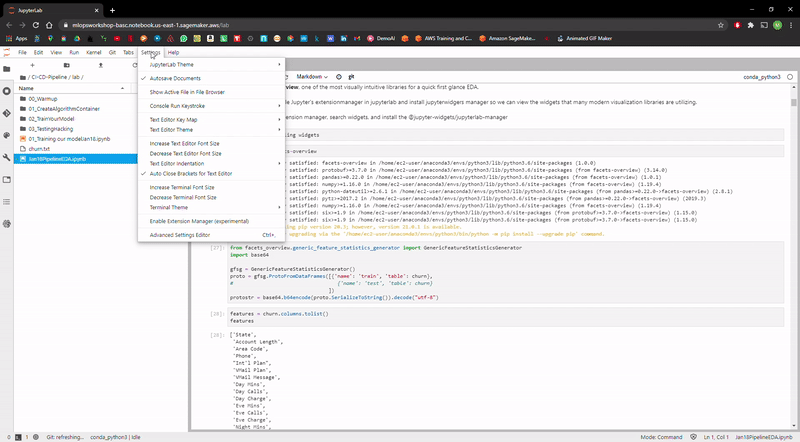

In [10]:
from IPython.display import Image
Image(filename='widgetsinstall.gif')

**Now lets install facets**

In [12]:
!pip3 install facets-overview

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


The Following two cells set up our visualization and loaded through an HTML iframe

In [13]:
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
import base64

gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': churn},
#                                   {'name': 'test', 'table': churn}
                                 ])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

In [20]:
# Display the facets overview visualization for this data
from IPython.core.display import display, HTML

HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

**Facets Dive**


Using Facets Dive we can slice our dataset in many difference ways understanding of the data

In [17]:
sprite_size = 32 if len(churn.index)>50000 else 64
jsonstr = churn.to_json(orient='records')

In [ ]:
# Display the Dive visualization for this data
from IPython.core.display import display, HTML

# Create Facets template  
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/master/facets-dist/facets-jupyter.html">
        <facets-dive sprite-image-width="{sprite_size}" sprite-image-height="{sprite_size}" id="elem" height="600"></facets-dive>
        <script>
          document.querySelector("#elem").data = {jsonstr};
        </script>"""

# Load the json dataset and the sprite_size into the template
html = HTML_TEMPLATE.format(jsonstr=jsonstr, sprite_size=sprite_size)

# Display the template
display(HTML(html))

We can also pull some general summary statistics of our data using traditional matplotlib overview

Account Length    Area Code  VMail Message     Day Mins    Day Calls  \
count     3333.000000  3333.000000    3333.000000  3333.000000  3333.000000   
mean       101.064806   437.182418       8.099010   179.775098   100.435644   
std         39.822106    42.371290      13.688365    54.467389    20.069084   
min          1.000000   408.000000       0.000000     0.000000     0.000000   
25%         74.000000   408.000000       0.000000   143.700000    87.000000   
50%        101.000000   415.000000       0.000000   179.400000   101.000000   
75%        127.000000   510.000000      20.000000   216.400000   114.000000   
max        243.000000   510.000000      51.000000   350.800000   165.000000   

        Day Charge     Eve Mins    Eve Calls   Eve Charge   Night Mins  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean     30.562307   200.980348   100.114311    17.083540   200.872037   
std       9.259435    50.713844    19.922625     4.310668    50.573847   
min       0.000000     0.000000     0.000000     0.000000    23.200000   
25%      24.430000   166.600000    87.000000    14.160000   167.000000   
50%      30.500000   201.400000   100.000000    17.120000   201.200000   
75%      36.790000   235.300000   114.000000    20.000000   235.300000   
max      59.640000   363.700000   170.000000    30.910000   395.000000   

       Night Calls  Night Charge    Intl Mins   Intl Calls  Intl Charge  \
count  3333.000000   3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.107711      9.039325    10.237294     4.479448     2.764581   
std      19.568609      2.275873     2.791840     2.461214     0.753773   
min      33.000000      1.040000     0.000000     0.000000     0.000000   
25%      87.000000      7.520000     8.500000     3.000000     2.300000   
50%     100.000000      9.050000    10.300000     4.000000     2.780000   
75%     113.000000     10.590000    12.100000     6.000000     3.270000   
max     175.000000     17.770000    20.000000    20.000000     5.400000   

       CustServ Calls  
count     3333.000000  
mean         1.562856  
std          1.315491  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          2.000000  
max          9.000000

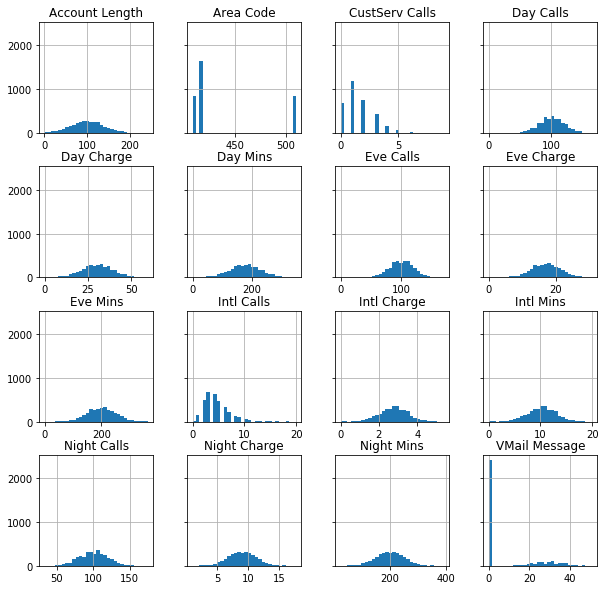

In [19]:
# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

---
**Looking at our data:**

State appears to be quite evenly distributed and therfore not relevant to prediction.

Phone # takes on too many unique values to be of any use. It's possible parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.

Only 14% of customers churned, so there is some class imabalance, but nothing extreme.

Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity. VMail Message being a notable exception, and Area Code showing up as a feature we should convert to non-numeric categorical).


So lets drop the unecessary features and convert area code:

In [45]:
churn = churn.drop('Phone', axis=1)
churn = churn.drop('State', axis=1)
churn['Area Code'] = churn['Area Code'].astype(object)

**Next let's look at the relationship between each of the features and our target variable.**

Churn?       False.     True.
Area Code                    
408        0.251228  0.252588
415        0.497895  0.488613
510        0.250877  0.258799

Churn?        False.     True.
Int'l Plan                    
no          0.934737  0.716356
yes         0.065263  0.283644

Churn?        False.     True.
VMail Plan                    
no          0.704561  0.834369
yes         0.295439  0.165631

Account Length


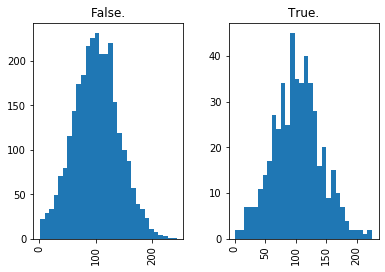

VMail Message


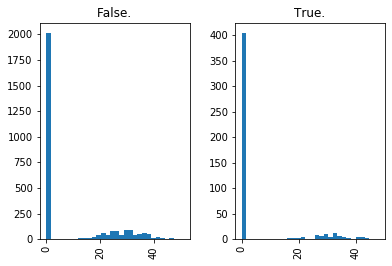

Day Mins


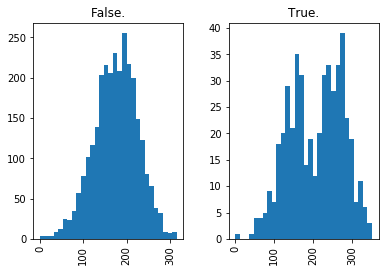

Day Calls


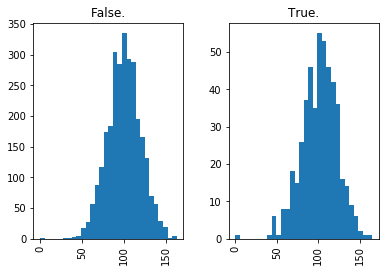

Eve Mins


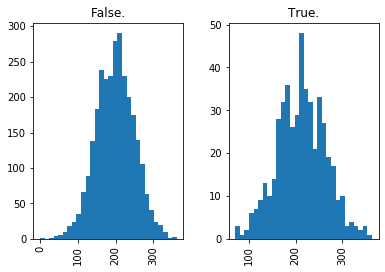

Eve Calls


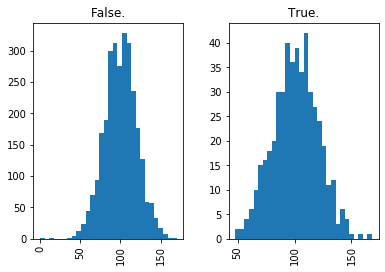

Night Mins


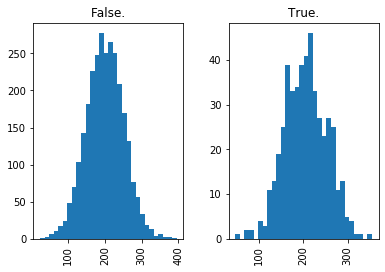

Night Calls


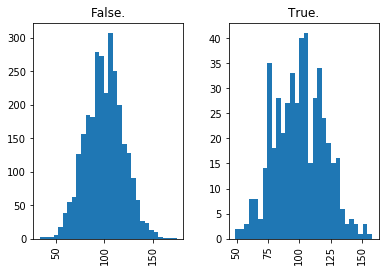

Intl Mins


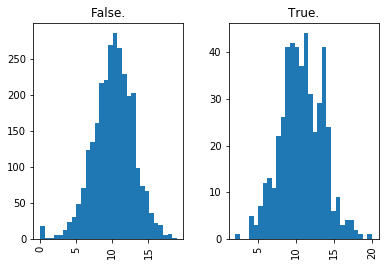

Intl Calls


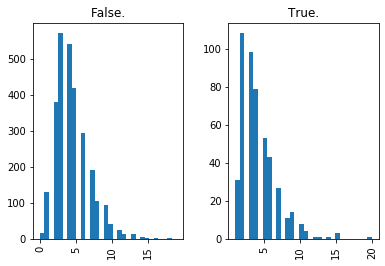

CustServ Calls


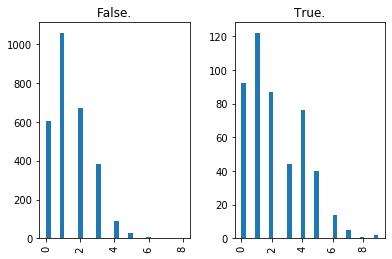

In [46]:
for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        display(pd.crosstab(index=churn[column], columns=churn['Churn?'], normalize='columns'))

for column in churn.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = churn[[column, 'Churn?']].hist(by='Churn?', bins=30)
    plt.show()

We can see that churners appear: 

Evenly geographically distributed.

More likely to have an international plan and less likely to have a voicemail plan.

Show some bimodality in daily minutes.

Have more customer service calls (which makes sense intuitively for churning customers).

**Lets run a correlation matrix as well:**





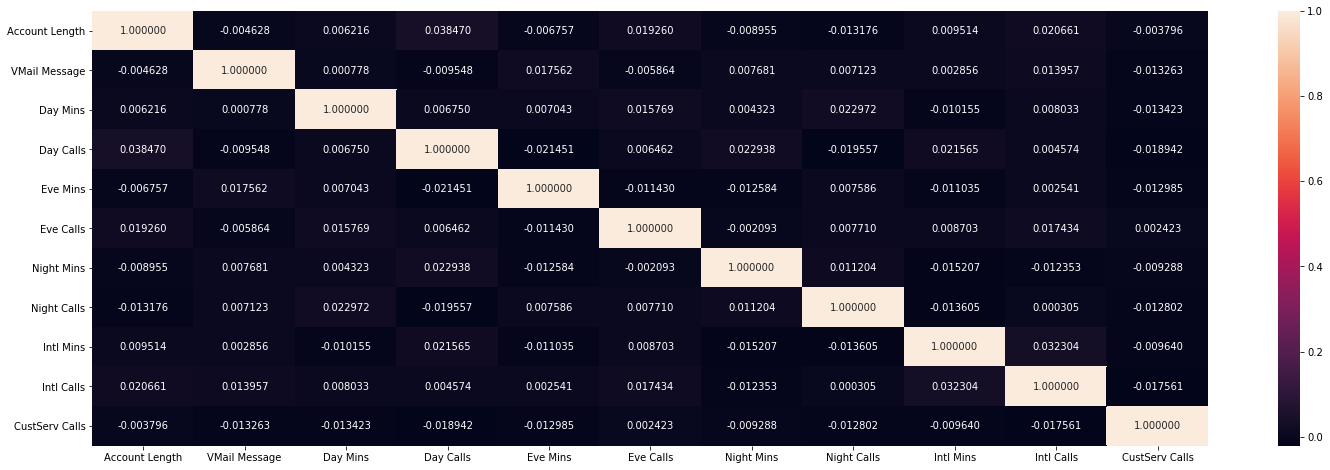

In [47]:
import seaborn as sns
corr = churn.corr()

f = plt.subplots(figsize=(25, 8))
sns.heatmap(corr, annot=True, fmt="f",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Multiple features have 100% correlation with one another. 

We should remove one of each of the redundant pairs as including both features could cause a reduncancy bias or worse, become highly problematic for training our model.

In [39]:
# drop redundant columns, 1 of each pair
churn = churn.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)


KeyError: "['Day Charge' 'Eve Charge' 'Night Charge' 'Intl Charge'] not found in axis"

In [48]:
churn

Account Length Area Code Int'l Plan VMail Plan  VMail Message  Day Mins  \
0                128       415         no        yes             25     265.1   
1                107       415         no        yes             26     161.6   
2                137       415         no         no              0     243.4   
3                 84       408        yes         no              0     299.4   
4                 75       415        yes         no              0     166.7   
...              ...       ...        ...        ...            ...       ...   
3328             192       415         no        yes             36     156.2   
3329              68       415         no         no              0     231.1   
3330              28       510         no         no              0     180.8   
3331             184       510        yes         no              0     213.8   
3332              74       415         no        yes             25     234.4   

      Day Calls  Eve Mins  Eve Calls  Night Mins  Night Calls  Intl Mins  \
0           110     197.4         99       244.7           91       10.0   
1           123     195.5        103       254.4          103       13.7   
2           114     121.2        110       162.6          104       12.2   
3            71      61.9         88       196.9           89        6.6   
4           113     148.3        122       186.9          121       10.1   
...         ...       ...        ...         ...          ...        ...   
3328         77     215.5        126       279.1           83        9.9   
3329         57     153.4         55       191.3          123        9.6   
3330        109     288.8         58       191.9           91       14.1   
3331        105     159.6         84       139.2          137        5.0   
3332        113     265.9         82       241.4           77       13.7   

      Intl Calls  CustServ Calls  Churn?  
0              3               1  False.  
1              3               1  False.  
2              5               0  False.  
3              7               2  False.  
4              3               3  False.  
...          ...             ...     ...  
3328           6               2  False.  
3329           4               3  False.  
3330           6               2  False.  
3331          10               2  False.  
3332           4               0  False.  

[3333 rows x 15 columns]

Let now build a model using XG boost, the popular and efficient open-source implementation of the gradient boosted trees algorithm. 

Gradient boosting is a supervised learning algorithm that attempts to accurately predict a target variable by combining an ensemble of estimates from a set of simpler and weaker models. The XGBoost algorithm performs well in machine learning because of its robust handling of a variety of data types, relationships, distributions, and the variety of hyperparameters that you can fine-tune. 

Lets use XGBoost algorithm as an Amazon SageMaker built-in algorithm. This implementation has a smaller memory footprint, better logging, improved hyperparameter validation, and an expanded set of metrics than the original versions. 
It provides an XGBoost estimator that executes a training script in a managed XGBoost environment. 

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format. We'll use the CSV format which in this case requires we:

Have the predictor variable in the first column

Not have a header row

We should also convert all our categorical features into numeric features:



In [49]:
model_data = pd.get_dummies(churn)


In [50]:
model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)

In [51]:
model_data


Churn?_True.  Account Length  VMail Message  Day Mins  Day Calls  \
0                0             128             25     265.1        110   
1                0             107             26     161.6        123   
2                0             137              0     243.4        114   
3                0              84              0     299.4         71   
4                0              75              0     166.7        113   
...            ...             ...            ...       ...        ...   
3328             0             192             36     156.2         77   
3329             0              68              0     231.1         57   
3330             0              28              0     180.8        109   
3331             0             184              0     213.8        105   
3332             0              74             25     234.4        113   

      Eve Mins  Eve Calls  Night Mins  Night Calls  Intl Mins  Intl Calls  \
0        197.4         99       244.7           91       10.0           3   
1        195.5        103       254.4          103       13.7           3   
2        121.2        110       162.6          104       12.2           5   
3         61.9         88       196.9           89        6.6           7   
4        148.3        122       186.9          121       10.1           3   
...        ...        ...         ...          ...        ...         ...   
3328     215.5        126       279.1           83        9.9           6   
3329     153.4         55       191.3          123        9.6           4   
3330     288.8         58       191.9           91       14.1           6   
3331     159.6         84       139.2          137        5.0          10   
3332     265.9         82       241.4           77       13.7           4   

      CustServ Calls  Area Code_408  Area Code_415  Area Code_510  \
0                  1              0              1              0   
1                  1              0              1              0   
2                  0              0              1              0   
3                  2              1              0              0   
4                  3              0              1              0   
...              ...            ...            ...            ...   
3328               2              0              1              0   
3329               3              0              1              0   
3330               2              0              0              1   
3331               2              0              0              1   
3332               0              0              1              0   

      Int'l Plan_no  Int'l Plan_yes  VMail Plan_no  VMail Plan_yes  
0                 1               0              0               1  
1                 1               0              0               1  
2                 1               0              1               0  
3                 0               1              1               0  
4                 0               1              1               0  
...             ...             ...            ...             ...  
3328              1               0              0               1  
3329              1               0              1               0  
3330              1               0              1               0  
3331              0               1              1               0  
3332              1               0              0               1  

[3333 rows x 19 columns]

In [52]:
pwd

'/home/ec2-user/SageMaker/CI-CD-Pipeline/lab'

In [53]:
model_data.to_csv("model_data.csv")

And now let's split the data into training, validation, and test sets:

In [54]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
np.savetxt("train_data.csv", train_data, delimiter=",", fmt='%0.3f')
np.savetxt("validation_data.csv", validation_data, delimiter=",", fmt='%0.3f')
np.savetxt("test_data.csv", test_data, delimiter=",", fmt='%0.3f')

# train_data.to_csv('churntrain.csv', header=False, index=False)
# validation_data.to_csv('churnvalidation.csv', header=False, index=False)

### Using Amazon SageMaker's built in XGBoost container we can train in a managed, distributed setting, and then host as a real-time prediction endpoint via a single line of code.

We'll also utilize Sagemaker's new debugger functionality capturing tensor metrics for model explainability with the popular explainability tool SHAP (SHapley Additive exPlanation), and the native integration of SHAP with Amazon SageMaker Debugger as well as training metrics in real-time including training and validation loss during regression.


### 1.1 Install and Import necessary libraries

In [55]:
import sys
import IPython
install_needed = False  # Set to True to upgrade
if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install -U sagemaker
    !{sys.executable} -m pip install -U smdebug
    IPython.Application.instance().kernel.do_shutdown(True)

In [30]:
!pip install shap
import shap

# print the JS visualization code to the notebook
shap.initjs()

     |████████████████████████████████| 352 kB 18.9 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=480240 sha256=7eb454de332c393980c5211160f95689b79025cdf9c70139381fe93dcec7c522
  Stored in directory: /home/ec2-user/.cache/pip/wheels/4d/b0/77/f9332e31f6af68b2e00450e9033ab768fe8765f1924d01d644
Successfully built shap
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [31]:
!pip install smdebug
import smdebug

     |████████████████████████████████| 260 kB 17.8 MB/s eta 0:00:01
     |████████████████████████████████| 85 kB 6.5 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [32]:
import boto3
import sagemaker
import os
from sagemaker import get_execution_role

### 1.2 AWS region and  IAM Role, S3 bucket and prefix to hold training data, debugger information, and model artifact

In [56]:
region = boto3.Session().region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))
print(bucket)
print(prefix)

AWS Region: us-east-1
RoleArn: arn:aws:iam::641395199407:role/MLOps
sagemaker-us-east-1-641395199407
sagemaker/CI-CD-Pipeline


## Section 2 - Data preparation <a id='prep-data'></a>

We'll be using the [SHAP](https://github.com/slundberg/shap) library to perform visual analysis.
So we'll need to split the into features and label for use with the SHAP visualizations:

In [57]:
X = model_data.iloc[:,1:]
X

Account Length  VMail Message  Day Mins  Day Calls  Eve Mins  Eve Calls  \
0                128             25     265.1        110     197.4         99   
1                107             26     161.6        123     195.5        103   
2                137              0     243.4        114     121.2        110   
3                 84              0     299.4         71      61.9         88   
4                 75              0     166.7        113     148.3        122   
...              ...            ...       ...        ...       ...        ...   
3328             192             36     156.2         77     215.5        126   
3329              68              0     231.1         57     153.4         55   
3330              28              0     180.8        109     288.8         58   
3331             184              0     213.8        105     159.6         84   
3332              74             25     234.4        113     265.9         82   

      Night Mins  Night Calls  Intl Mins  Intl Calls  CustServ Calls  \
0          244.7           91       10.0           3               1   
1          254.4          103       13.7           3               1   
2          162.6          104       12.2           5               0   
3          196.9           89        6.6           7               2   
4          186.9          121       10.1           3               3   
...          ...          ...        ...         ...             ...   
3328       279.1           83        9.9           6               2   
3329       191.3          123        9.6           4               3   
3330       191.9           91       14.1           6               2   
3331       139.2          137        5.0          10               2   
3332       241.4           77       13.7           4               0   

      Area Code_408  Area Code_415  Area Code_510  Int'l Plan_no  \
0                 0              1              0              1   
1                 0              1              0              1   
2                 0              1              0              1   
3                 1              0              0              0   
4                 0              1              0              0   
...             ...            ...            ...            ...   
3328              0              1              0              1   
3329              0              1              0              1   
3330              0              0              1              1   
3331              0              0              1              0   
3332              0              1              0              1   

      Int'l Plan_yes  VMail Plan_no  VMail Plan_yes  
0                  0              0               1  
1                  0              0               1  
2                  0              1               0  
3                  1              1               0  
4                  1              1               0  
...              ...            ...             ...  
3328               0              0               1  
3329               0              1               0  
3330               0              1               0  
3331               1              1               0  
3332               0              0               1  

[3333 rows x 18 columns]

In [58]:
y = model_data.iloc[:,:1]
y

Churn?_True.
0                0
1                0
2                0
3                0
4                0
...            ...
3328             0
3329             0
3330             0
3331             0
3332             0

[3333 rows x 1 columns]

In [59]:
# import shap
# X, y = shap.datasets.adult()
# X_display, y_display = shap.datasets.adult(display=True)
# feature_names = list(X.columns)

In [60]:
feature_names = list(X.columns)
feature_names

['Account Length',
 'VMail Message',
 'Day Mins',
 'Day Calls',
 'Eve Mins',
 'Eve Calls',
 'Night Mins',
 'Night Calls',
 'Intl Mins',
 'Intl Calls',
 'CustServ Calls',
 'Area Code_408',
 'Area Code_415',
 'Area Code_510',
 "Int'l Plan_no",
 "Int'l Plan_yes",
 'VMail Plan_no',
 'VMail Plan_yes']

In [43]:
# train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
# np.savetxt("train_data.csv", train_data, delimiter=",", fmt='%0.3f')
# np.savetxt("validation_data.csv", validation_data, delimiter=",", fmt='%0.3f')
# np.savetxt("test_data.csv", test_data, delimiter=",", fmt='%0.3f')

# # train_data.to_csv('churntrain.csv', header=False, index=False)
# # validation_data.to_csv('churnvalidation.csv', header=False, index=False)

In [70]:
# # create a train/test split
# from sklearn.model_selection import train_test_split   # For splitting the dataset
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=7)
# X_train_display = X_display.loc[X_train.index]

In [61]:
pwd

'/home/ec2-user/SageMaker/CI-CD-Pipeline/lab'

In [62]:
prefix

'sagemaker/CI-CD-Pipeline'

Lets upload our data to S3 where sagemaker can acesses it:

In [63]:
# train = pd.concat([pd.Series(y_train, index=X_train.index,
#                              name='Churn?', dtype=int), X_train], axis=1)
# test = pd.concat([pd.Series(y_test, index=X_test.index,
#                             name='Churn?', dtype=int), X_test], axis=1)

# # Use 'csv' format to store the data
# # The first column is expected to be the output column
# train.to_csv('train.csv', index=False, header=False)
# test.to_csv('validation.csv', index=False, header=False)

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/train_data.csv')).upload_file('train_data.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(
    prefix, 'data/validation_data.csv')).upload_file('validation_data.csv')

## Section 3 - Train XGBoost model in Amazon SageMaker with  debugger enabled. <a id='train'></a>

Lets now train an XGBoost model with Amazon SageMaker Debugger enabled and monitor the training jobs. This is done using the Amazon SageMaker Estimator API. While the training job is running, use Amazon SageMaker Debugger API to access saved model parameters in real time and visualize them.

### 3.2 Build the XGBoost container

Amazon SageMaker Debugger is available in Amazon SageMaker XGBoost container version 0.90-2 or later.

In [65]:
container=sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")
container

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

Lets add some general hyperparemeters, we'll perform hyper parameter tuning later so lets not worry about getting these exactly right.

In [66]:
base_job_name = "sm-debug-shap"
bucket_path = 's3://{}'.format(bucket)

hyperparameters = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.8",
    "silent": "0",
    "objective": "binary:logistic",
    "num_round": "100",
}
save_interval = 5

### 3.3 Enabling Debugger in Estimator object


#### DebuggerHookConfig

Enabling Amazon SageMaker Debugger in training job can be accomplished by adding its configuration into Estimator object constructor:

```python
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

estimator = Estimator(
    ...,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path="s3://{bucket_name}/{location_in_bucket}",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "10"
                }
            )
        ]
    )
)
```
Here, the `DebuggerHookConfig` object instructs `Estimator` what data we are interested in.
Two parameters are provided in the example:

- `s3_output_path`: Points to an S3 bucket where you intend to store model parameters. Amount of data saved depends on multiple factors, major ones are training job, data set, model, frequency of saving model parameters. This S3 bucket should be in your AWS account so that you have full access to control over the stored data. **Note**: The S3 bucket should be originally created in the same Region where your training job is running, otherwise you might run into problems with cross-Region access.

- `collection_configs`: It enumerates named collections of model parameters to save. Collections are a convenient way to organize relevant model parameters under same umbrella to make it easy to navigate them during analysis. In this particular example, you are interested in a single collection named metrics. You also configured Amazon SageMaker Debugger to save metrics every 10 iterations. See [Collection](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#collection) documentation for all parameters that are supported by Collections and DebuggerConfig documentation for more details about all parameters DebuggerConfig supports.
  
#### Rules

Enabling Rules in training job can be accomplished by adding the `rules` configuration into Estimator object constructor.

- `rules`: This parameter will accept a list of rules you want to evaluate against training jobs.
  For rules, Amazon SageMaker Debugger supports two types:
  - SageMaker Rules: These are rules specially curated by the data science and engineering teams in Amazon SageMaker which you can opt to evaluate against your training job.
  - Custom Rules: You can optionally choose to write your own rule as a Python source file and have it evaluated against your training job.
    To provide Amazon SageMaker Debugger to evaluate this rule, you would have to provide the S3 location of the rule source and the evaluator image.

In this example, you will use a Amazon SageMaker's LossNotDecreasing rule, which helps you identify if you are running into a situation where the training loss is not going down.

```python
from sagemaker.debugger import rule_configs, Rule

estimator = Estimator(
    ...,
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ],
)
```

- `rule_parameters`: In this parameter, you provide the runtime values of the parameter in your constructor.
  You can still choose to pass in other values which may be necessary for your rule to be evaluated.
  In this example, you will use Amazon SageMaker's LossNotDecreasing rule to monitor the `metircs` collection.
  The rule will alert you if the loss value in the `metrics` collection has not decreased for more than 10 steps.

In [67]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator

xgboost_estimator = Estimator(
    role=role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type='ml.m4.xlarge',
#     instance_type='local',
    image_uri=container,
    hyperparameters=hyperparameters,
    max_run=1800,
#     sagemaker_session=None,

    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=bucket_path,  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="full_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
        ],
    ),

    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        ),
    ],
)

With the next step, we'll start a training job by using the Estimator object you created above. 

In [68]:
from sagemaker.session import TrainingInput

train_input = TrainingInput("s3://{}/{}/{}".format(bucket,
                                              prefix, "data/train_data.csv"), content_type="csv")
validation_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/validation_data.csv"), content_type="csv")

# s3_input_train = TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
# s3_input_validation = TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

xgboost_estimator.fit(
    {"train": train_input, "validation": validation_input},
    wait=False)

    # "wait=False"  This is a fire and forget event. 
    # By setting wait=False, you submit the job to run in the background.
    # Amazon SageMaker starts one training job and release control to next cells in the notebook.
    # Follow this notebook to see status of the training job.
    

### 3.4 Result

As a result of the above command, Amazon SageMaker starts **one training job and one rule job** for you. The first one is the job that produces the model parameters to be analyzed. The second one analyzes the model parameters to check if `train-error` and `validation-error` are not decreasing at any point during training.

Check the status of the training job below.
After your training job is started, Amazon SageMaker starts a rule-execution job to run the LossNotDecreasing rule.  

The cell below will block till the training job is complete.

In [69]:
import time

for _ in range(36):
    job_name = xgboost_estimator.latest_training_job.name
    client = xgboost_estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = xgboost_estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print("Training job status: {}, Rule Evaluation Status: {}".format(training_job_status, rule_evaluation_status))
    
    if training_job_status in ["Completed", "Failed"]:
        break

    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

### 3.4 Result

As a result of the above command, Amazon SageMaker starts **one training job and one rule job** for you. The first one is the job that produces the model parameters to be analyzed. The second one analyzes the model parameters to check if `train-error` and `validation-error` are not decreasing at any point during training.

Check the status of the training job below.
After your training job is started, Amazon SageMaker starts a rule-execution job to run the LossNotDecreasing rule.  

The cell below will block till the training job is complete.

In [85]:
# import time

# for _ in range(36):
#     job_name = xgboost_estimator.latest_training_job.name
#     client = xgboost_estimator.sagemaker_session.sagemaker_client
#     description = client.describe_training_job(TrainingJobName=job_name)
#     training_job_status = description["TrainingJobStatus"]
#     rule_job_summary = xgboost_estimator.latest_training_job.rule_job_summary()
#     rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
#     print("Training job status: {}, Rule Evaluation Status: {}".format(training_job_status, rule_evaluation_status))
    
#     if training_job_status in dd["Completed", "Failed"]:
#         break

#     time.sleep(10)

Training job status: Completed, Rule Evaluation Status: IssuesFound


### 3.5 Check the status of the Rule Evaluation Job

To get the rule evaluation job that Amazon SageMaker started for you, run the command below. The results show you the `RuleConfigurationName`, `RuleEvaluationJobArn`, `RuleEvaluationStatus`, `StatusDetails`, and `RuleEvaluationJobArn`.
If the model parameters meet a rule evaluation condition, the rule execution job throws a client error with `RuleEvaluationConditionMet`.

The logs of the rule evaluation job are available in the Cloudwatch Logstream `/aws/sagemaker/ProcessingJobs` with `RuleEvaluationJobArn`.

You can see that once the rule execution job starts, it identifies the loss not decreasing situation in the training job, it raises the `RuleEvaluationConditionMet` exception, and it ends the job.

In [70]:
xgboost_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:641395199407:processing-job/sm-debug-shap-2021-02-08-1-lossnotdecreasing-197fc673',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2021, 2, 8, 18, 54, 53, 303000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'ProfilerReport-1612810062',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:641395199407:processing-job/sm-debug-shap-2021-02-08-1-profilerreport-1612810062-b511cd63',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2021, 2, 8, 18, 53, 11, 722000, tzinfo=tzlocal())}]

## Section 4 - Analyze debugger output <a id='analyze-debugger-ouput'></a>

Now that you've trained the system, analyze the data.  Here, you focus on after-the-fact analysis.

You import a basic analysis library, which defines the concept of trial, which represents a single training run.

### Retrieving and Analyzing tensors

Before getting to analysis, here are some notes on concepts being used in Amazon SageMaker Debugger that help with analysis.
- ***Trial*** - Object that is a centerpiece of the SageMaker Debugger API when it comes to getting access to model parameters. It is a top level abstract that represents a single run of a training job. All model parameters emitted by a training job are associated with its trial.
- ***Tensor*** - Object that represents model parameters, such as weights, gradients, accuracy, and loss, that are saved during training job.

For more details on aforementioned concepts as well as on SageMaker Debugger API in general (including examples) see [SageMaker Debugger Analysis API](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md) documentation.

In the following code cell, use a ***Trial*** to access model parameters. You can do that by inspecting currently running training job and extract necessary parameters from its debug configuration to instruct SageMaker Debugger where the data you are looking for is located. Keep in mind the following:
- model parameters are being stored in your own S3 bucket to which you can navigate and manually inspect its content if desired.
- You might notice a slight delay before trial object is created. This is normal as SageMaker Debugger monitors the corresponding bucket and waits until model parameters to appear. The delay is introduced by less than instantaneous upload of model parameters from a training container to your S3 bucket. 

In [71]:
from smdebug.trials import create_trial

s3_output_path = xgboost_estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2021-02-08 18:58:18.026 ip-172-16-3-116:12916 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-02-08 18:58:18.041 ip-172-16-3-116:12916 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-641395199407/sm-debug-shap-2021-02-08-18-47-42-468/debug-output


You can list all model parameters that you want to analyze. Each one of these names is the name of a model parameter. The name is a combination of the feature name, which in these cases, is auto-assigned by XGBoost, and whether it's an evaluation metric, feature importance, or SHAP value.

In [72]:
trial.tensor_names()

[2021-02-08 18:58:24.024 ip-172-16-3-116:12916 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-02-08 18:58:25.050 ip-172-16-3-116:12916 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f2',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f10',
 'feature_importance/cover/f14',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f10',
 'feature_importance/gain/f14',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f

For each model parameter, we can get the values at all saved steps. 

In [73]:
trial.tensor("average_shap/f1").values()

{0: array([-5.615634e-05], dtype=float32),
 5: array([-0.00133741], dtype=float32),
 10: array([-0.00458301], dtype=float32),
 15: array([-0.00574622], dtype=float32),
 20: array([-0.00960953], dtype=float32),
 25: array([-0.01435525], dtype=float32),
 30: array([-0.01753493], dtype=float32),
 35: array([-0.01579096], dtype=float32),
 40: array([-0.01810881], dtype=float32),
 45: array([-0.01810881], dtype=float32),
 50: array([-0.01810881], dtype=float32),
 55: array([-0.01810881], dtype=float32),
 60: array([-0.01810881], dtype=float32),
 65: array([-0.01810881], dtype=float32),
 70: array([-0.02059131], dtype=float32),
 75: array([-0.02059131], dtype=float32),
 80: array([-0.02059131], dtype=float32),
 85: array([-0.02059131], dtype=float32),
 90: array([-0.02059131], dtype=float32),
 95: array([-0.02059131], dtype=float32)}

### Plot Performance metrics

You can also create a simple function that visualizes the training and validation errors as the training progresses.
The error should get smaller over time, as the system converges to a good solution.

In [74]:
from itertools import islice
import matplotlib.pyplot as plt
import re

MAX_PLOTS = 35

def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1]=="f{}".format(str(ifeat)): return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = (trial.collection(collection_name).tensor_names)
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

**Since our dataset is so small, we can clearly see how we would benefit from more training data to imporove the model's ability to generalize for predictions on the validation data and improve validation error.**

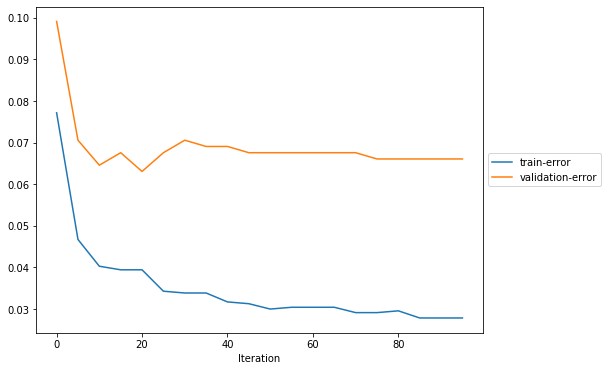

In [75]:
plot_collection(trial, "metrics")

### Feature importance

You can also visualize the feature priorities as determined by
[xgboost.get_score()](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score).
If you instructed Estimator to log the `feature_importance` collection, all importance types supported by `xgboost.get_score()` will be available in the collection.

In [76]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = [
        "weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(
            f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

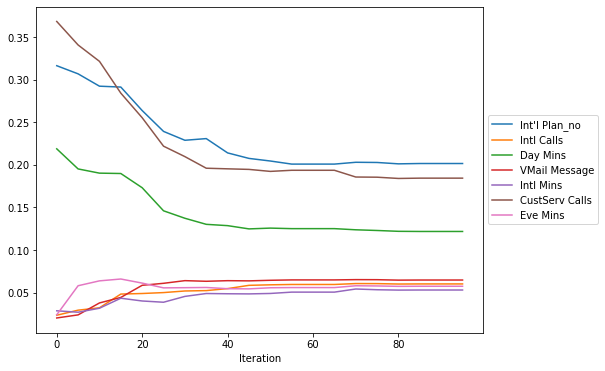

In [77]:
plot_feature_importance(trial, importance_type="cover")

### SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is
another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in a model's prediction output.
You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculated by [xgboost.predict(pred_contribs=True)](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.predict)) will be available the `average_shap` collection.

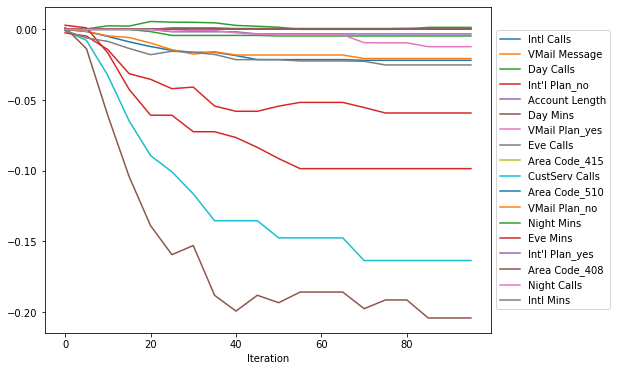

In [78]:
plot_collection(trial, "average_shap")

### Global explanations

Global explanatory methods allow understanding the model and its feature contributions in aggregate over multiple datapoints. Here we show an aggregate bar plot that plots the mean absolute SHAP value for each feature. 

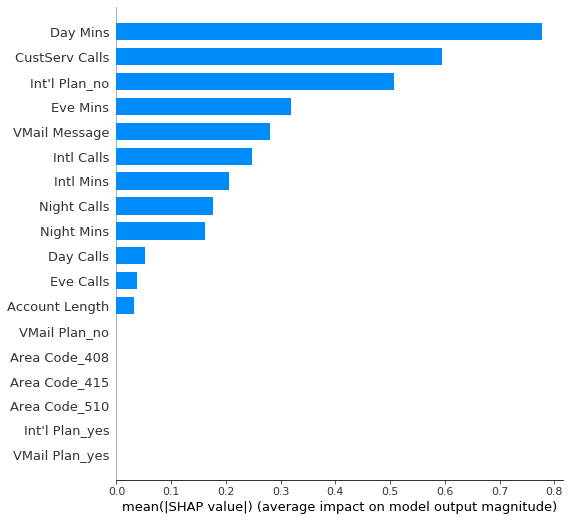

In [79]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type='bar', feature_names=feature_names)

In [80]:
shap_base_value

-2.331357

The detailed summary plot below can provide more context over the above bar chart. It tells which features are most important and, in addition, their range of effects over the dataset. The color allows us to match how changes in the value of a feature effect the change in prediction. 

The 'red' indicates higher value of the feature and 'blue' indicates lower (normalized over the features). This allows conclusions such as 'increase in Day Mins leads to higher log odds for prediction, leading to `True` predictions more often. 

We'll drop the label from our training data so it only includes features and then use the data to visualize how each feature affected the model's global prediction scores.

In [84]:
train_data_features = train_data.iloc[:,1:]

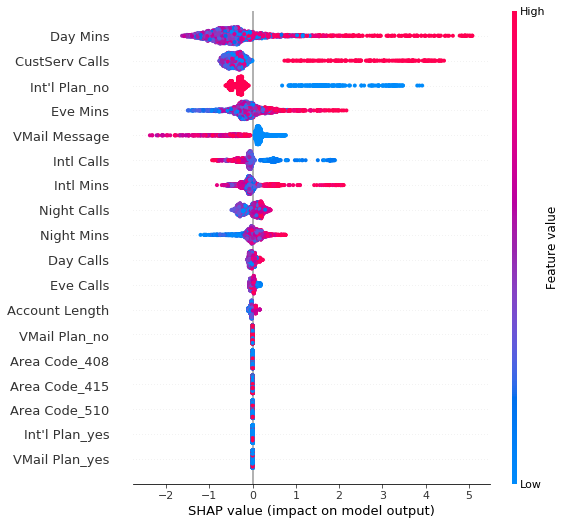

In [85]:
shap.summary_plot(shap_no_base, train_data_features)

### Local explanations

Local explainability aims to explain model behavior for a fixed input point. This can be used for either auditing models before deployment or to provide explanations for specific inference predictions. 

In [96]:
shap.initjs()

#### Force plot

A force plot explanation shows how features are contributing to push the model output from the base value (the average model output over the dataset) to the model output. Features pushing the prediction higher are shown in **red**, those pushing the prediction lower are in **blue**.

In [97]:
shap.force_plot(shap_base_value, shap_no_base[100, :],
                train_data_features.iloc[100, :], link="logit", matplotlib=False)

#### Stacked force plot

SHAP allows stacking multiple force-plots after rotating 90 degress to understand the explanations for multiple datapoints. If Javascript is enabled, then in the notebook this plot is interactive, allowing understanding the change in output for each feature independently. This stacking of force plots provides a balance between local and global explainability.

In [89]:
import numpy as np
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(500, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [98]:
shap.force_plot(shap_base_value,
                shap_no_base[sampled_indices, :],
                train_data_features.iloc[sampled_indices, :],
                link='logit')

## Dependence plots

To help reveal interactions between features, dependence_plot by default set on "auto" automatically selects what seems to be the strongest interaction.
Here we need to use our original train_data which includes the label for this type of analysis

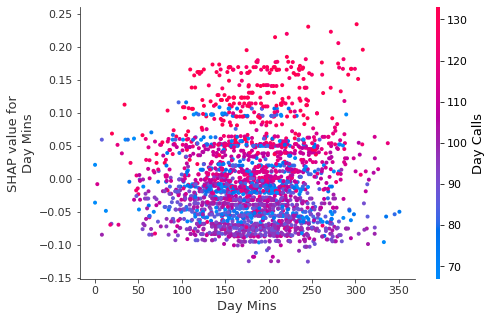

In [109]:
Target = 'Day Mins'
shap.dependence_plot(Target, shap_values, train_data)

We can plot auto dependencey interaction plots fo

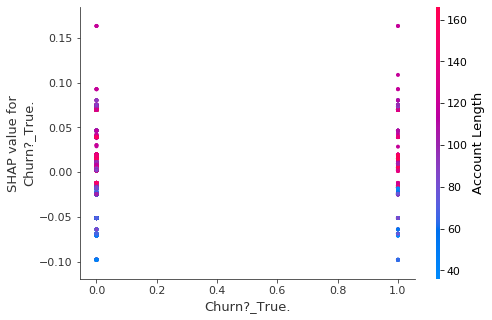

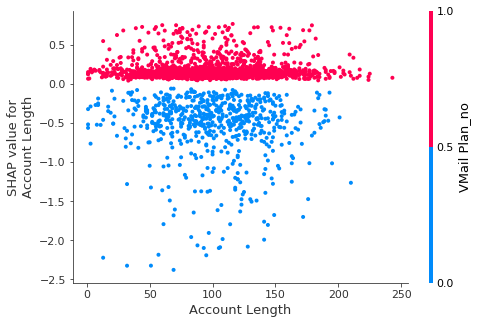

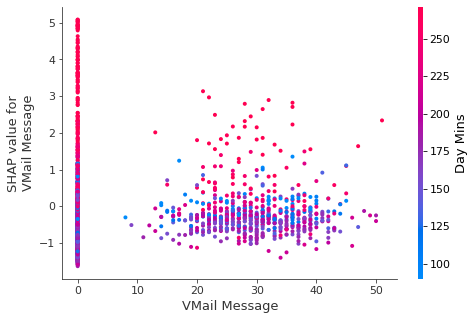

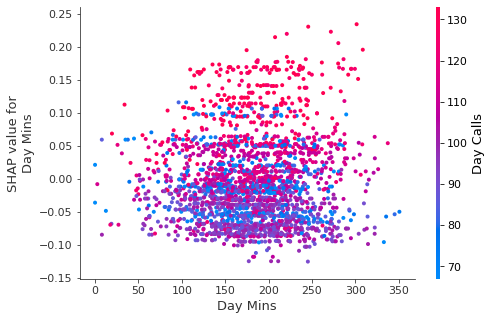

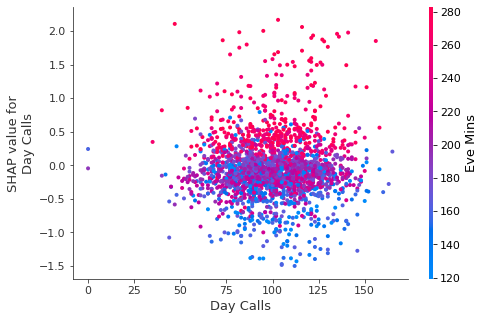

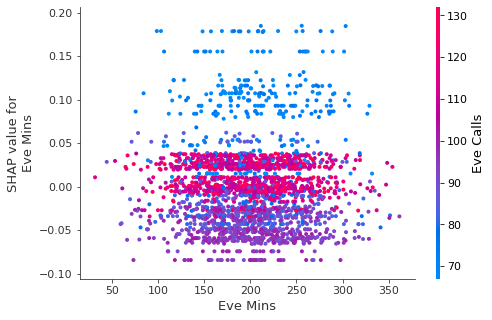

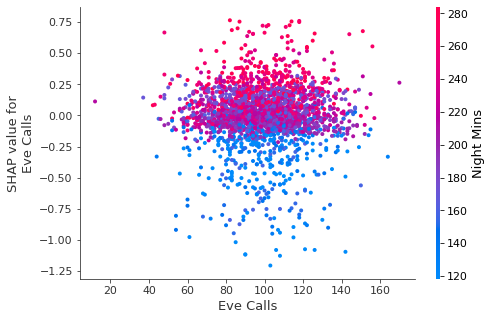

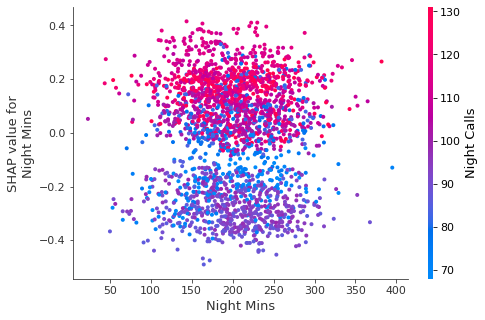

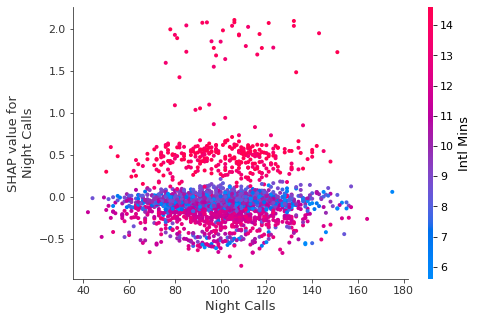

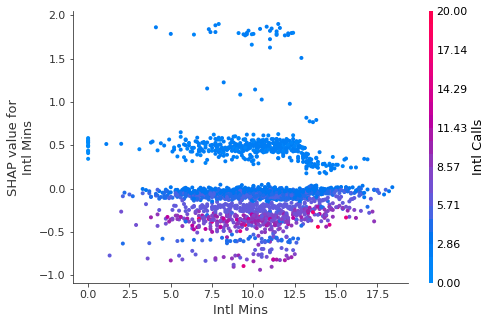

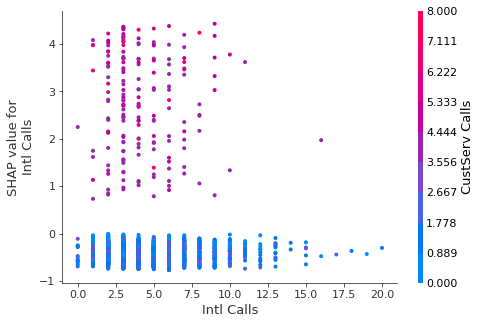

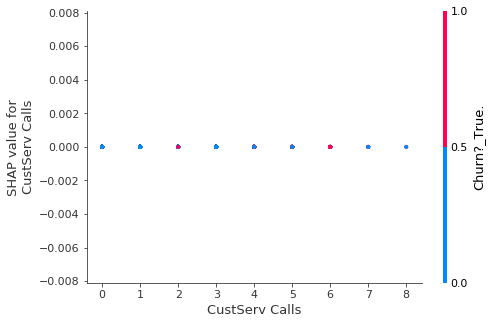

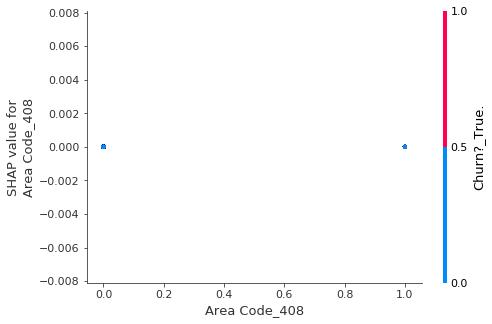

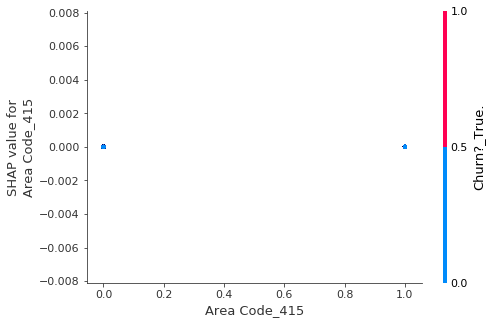

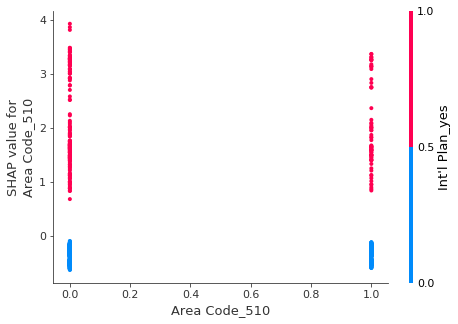

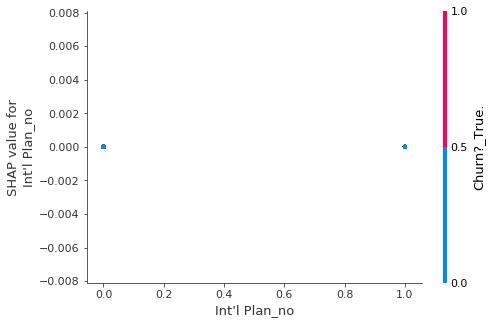

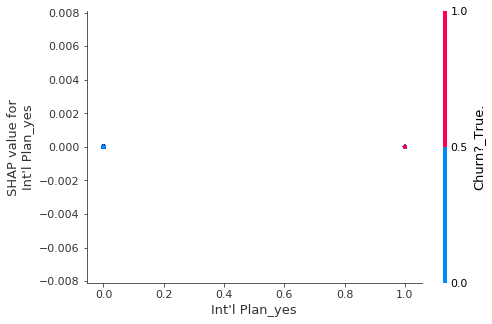

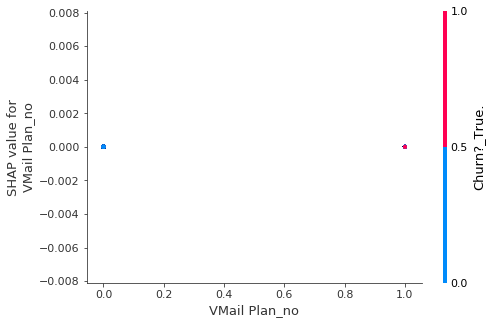

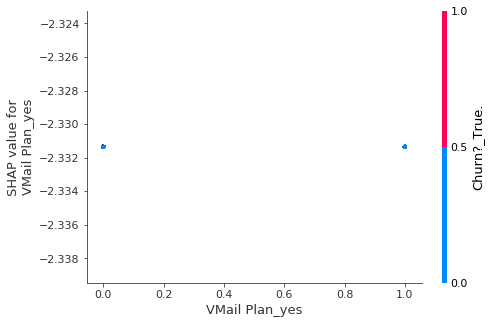

In [110]:
for name in train_data.columns:
    shap.dependence_plot(name, shap_values, train_data, display_features=train_data)

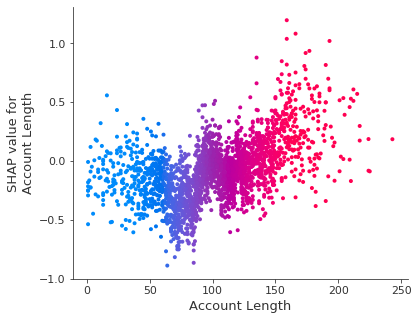

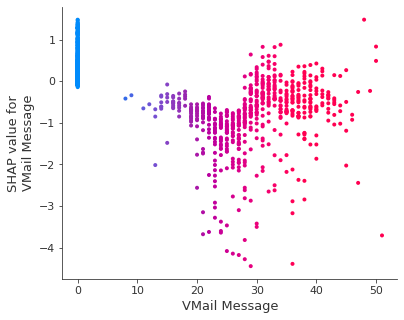

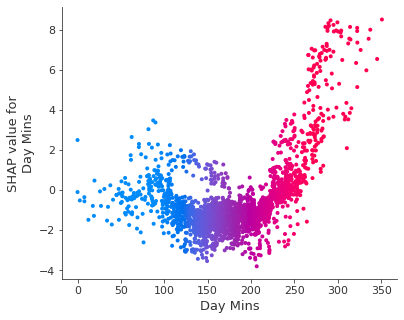

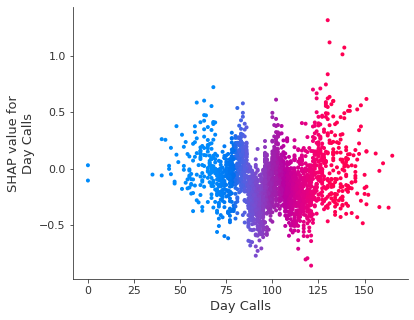

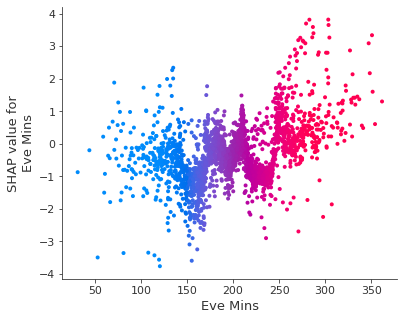

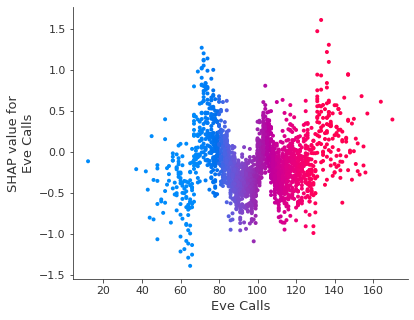

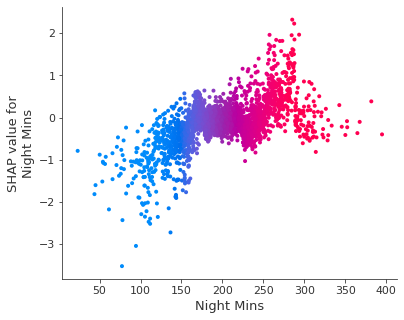

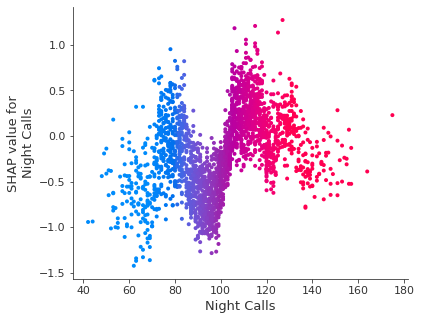

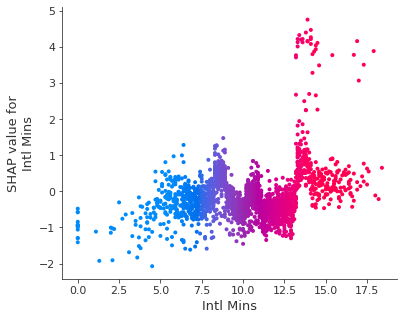

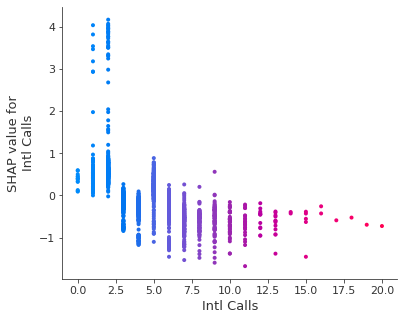

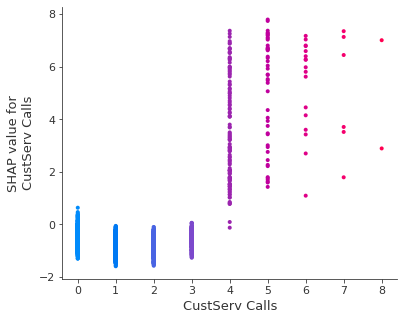

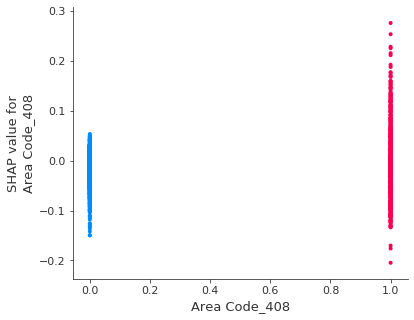

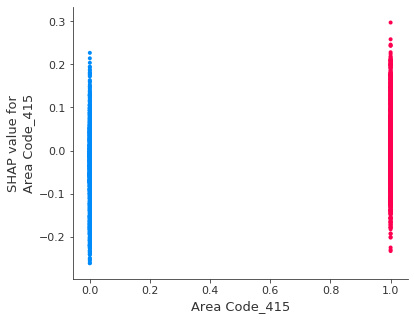

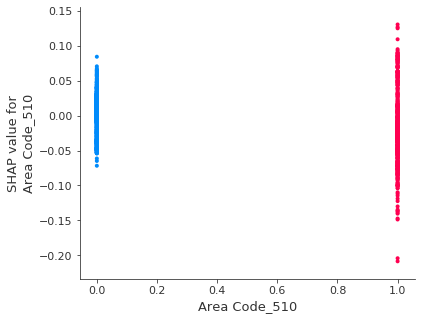

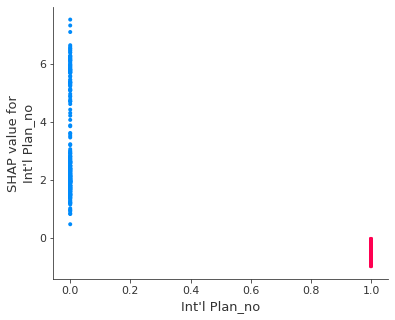

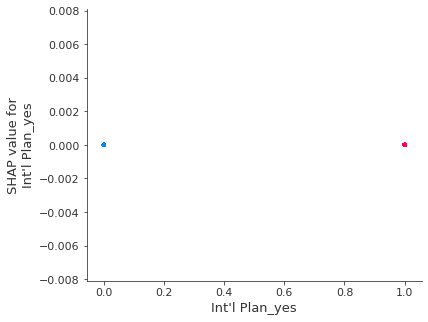

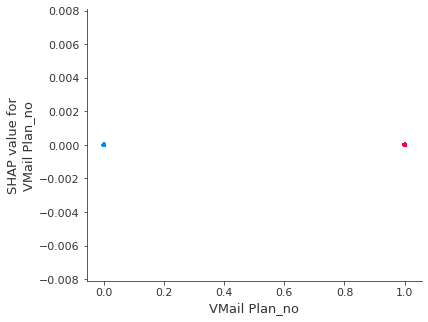

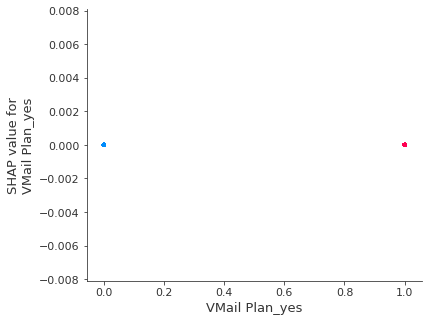

In [85]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train, interaction_index=name)

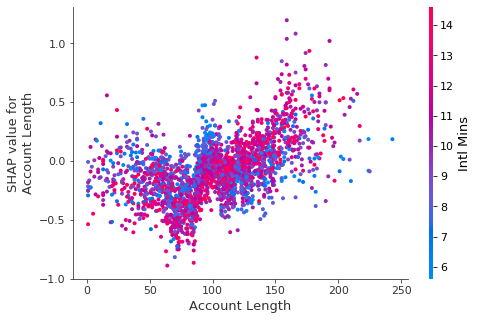

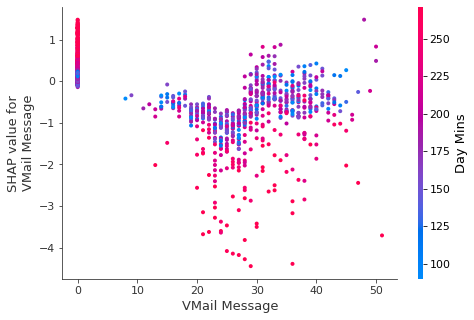

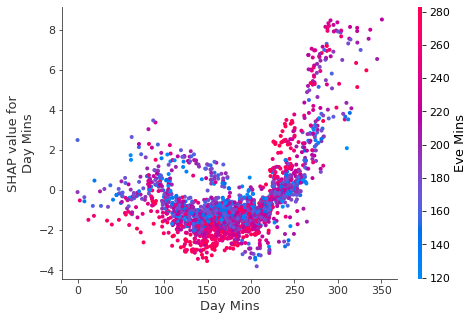

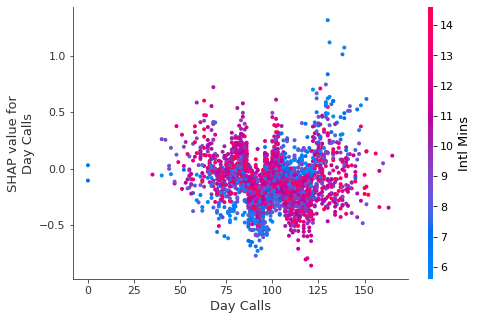

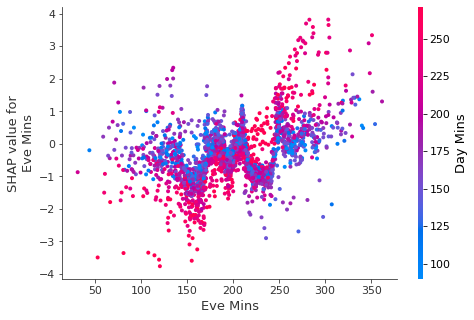

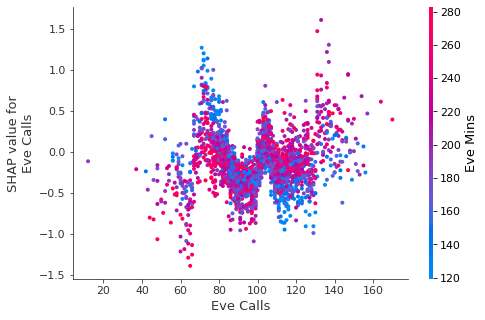

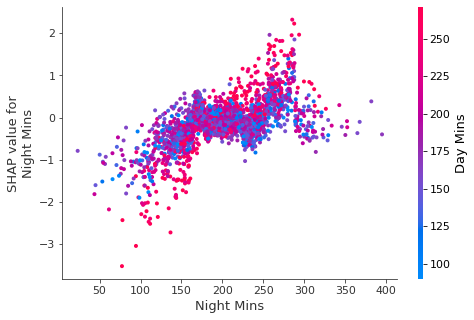

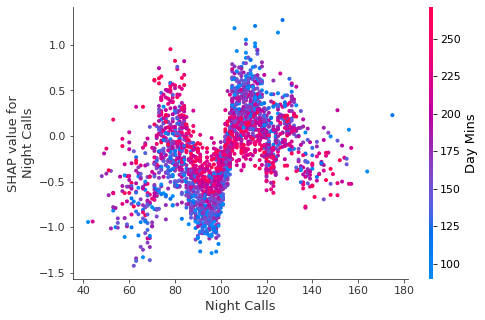

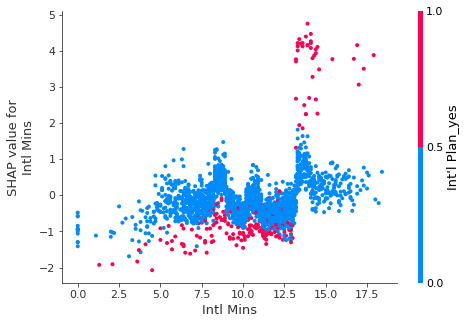

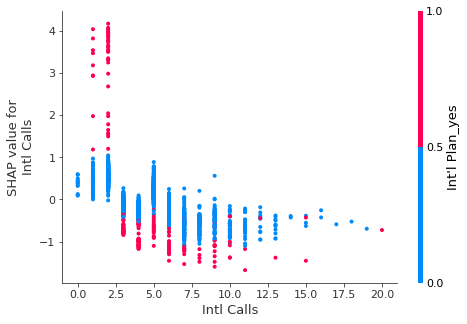

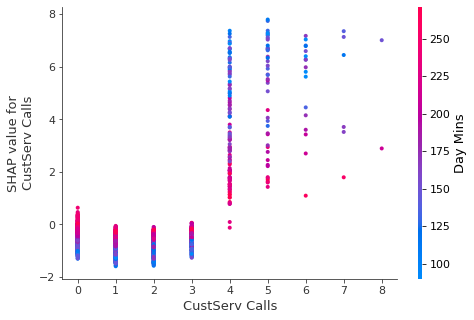

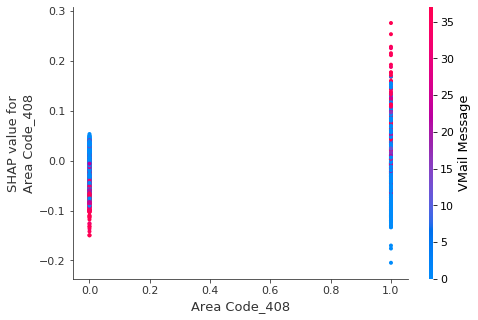

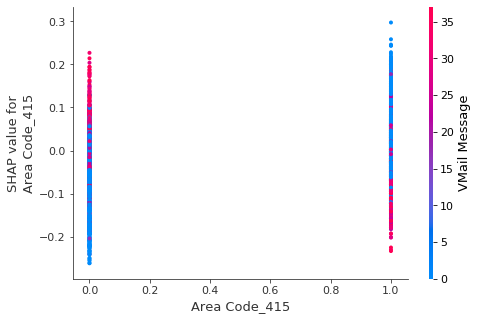

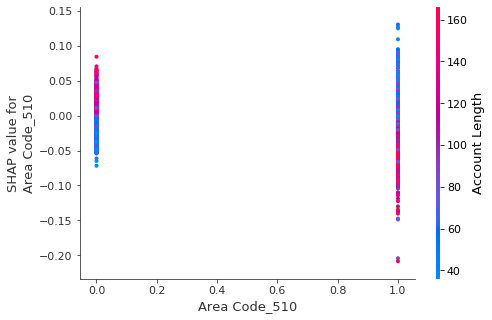

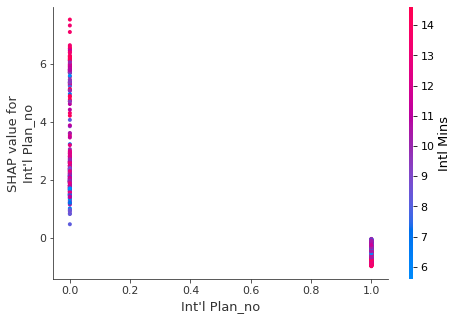

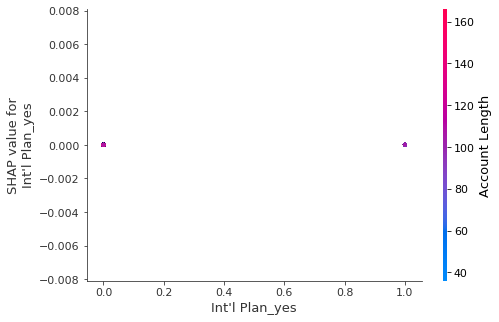

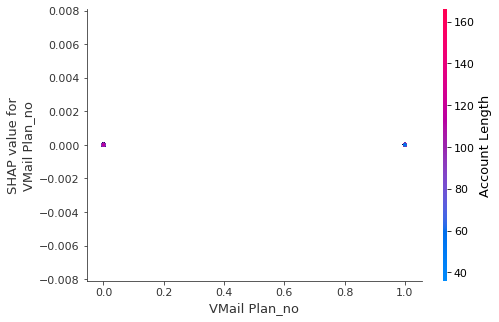

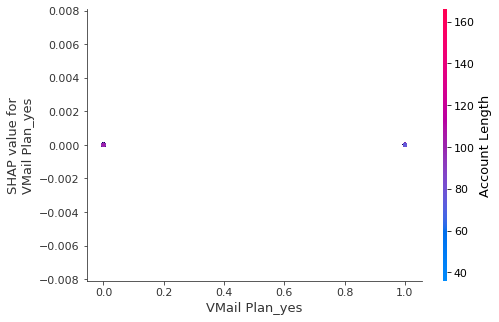

In [91]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train)

**TSNE Clustering Visualizations**

In [99]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as pl


shap_pca50 = PCA(n_components=12).fit_transform(shap_values[:1000,:])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000,:])

In [100]:

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

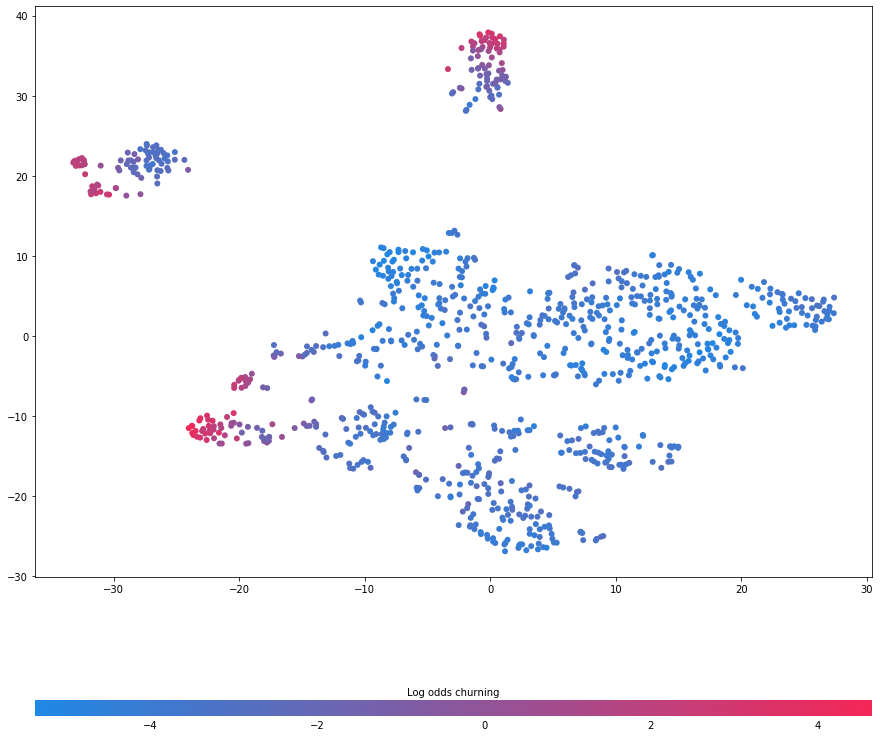

In [101]:
f = pl.figure(figsize=(15,15))
pl.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values[:1000,:].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = pl.colorbar(label="Log odds churning", aspect=50, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("on")
pl.show()

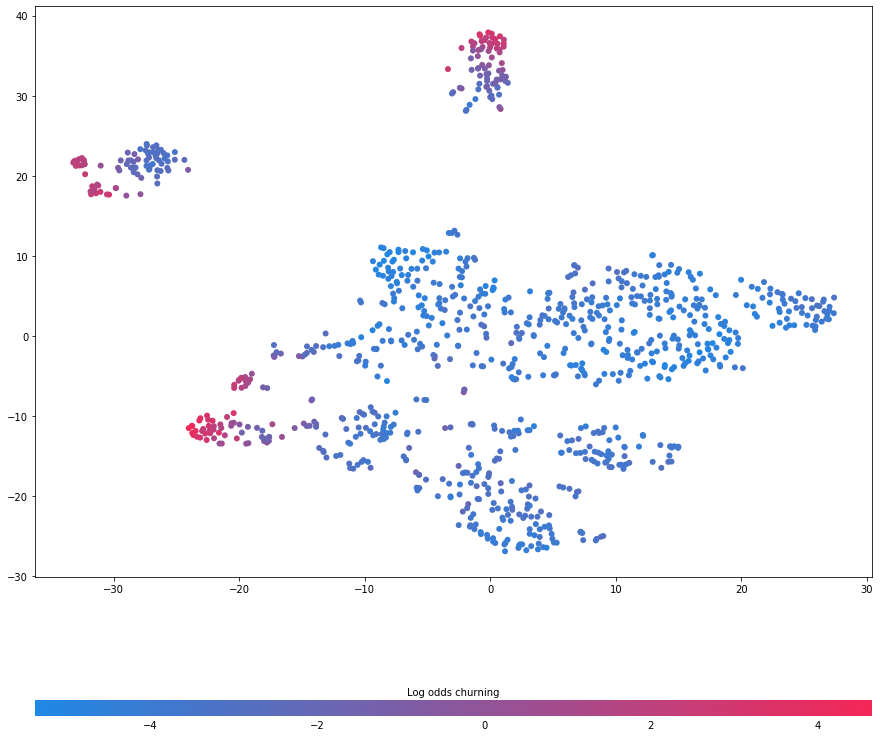

In [102]:
f = pl.figure(figsize=(15,15))
pl.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values[:1000,:].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = pl.colorbar(label="Log odds churning", aspect=50, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("on")
pl.show()

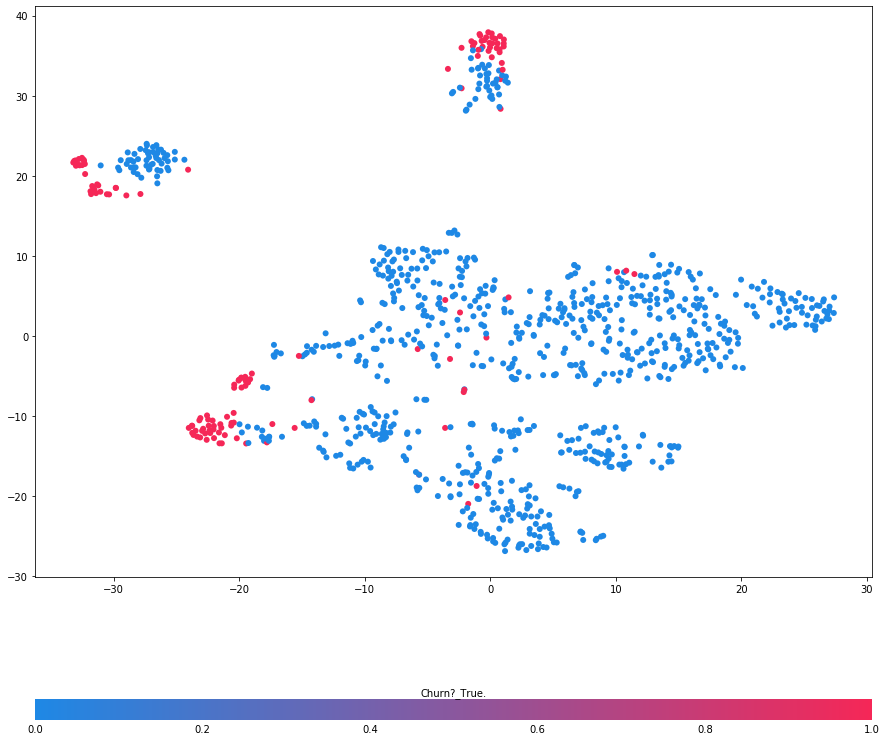

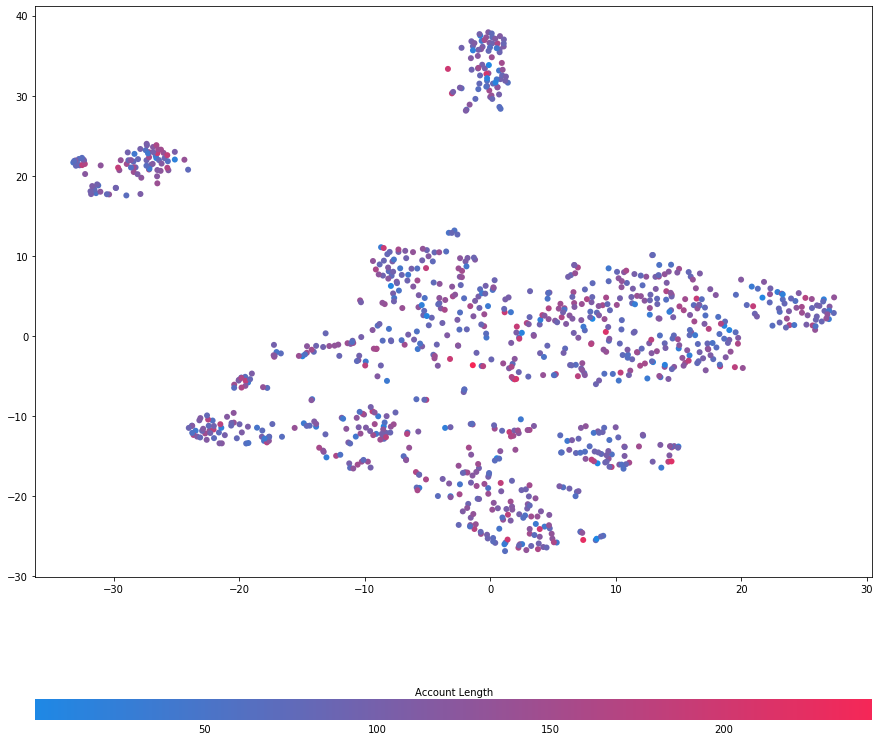

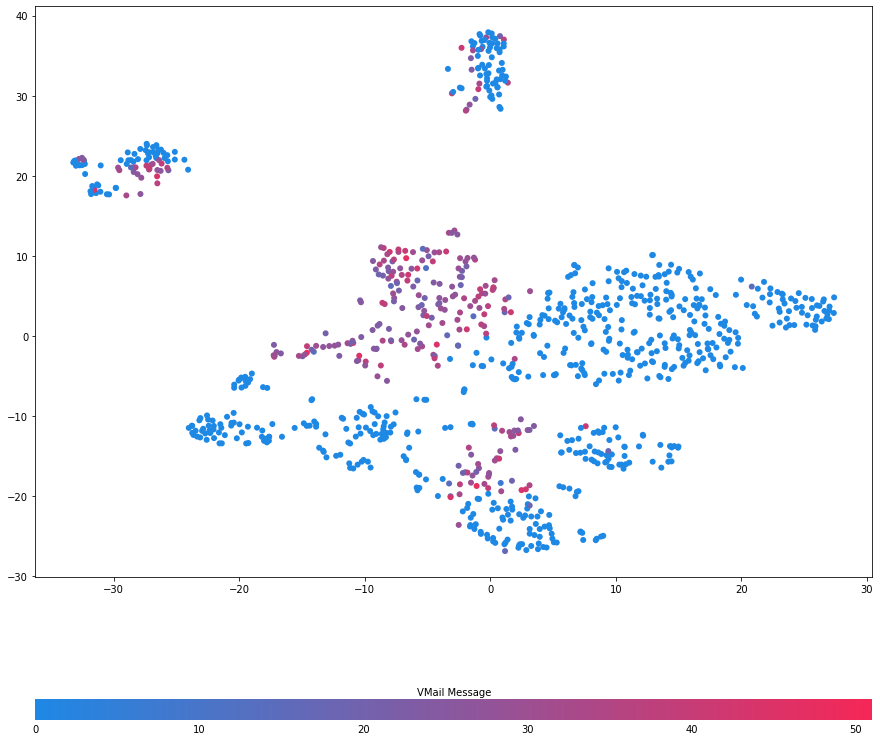

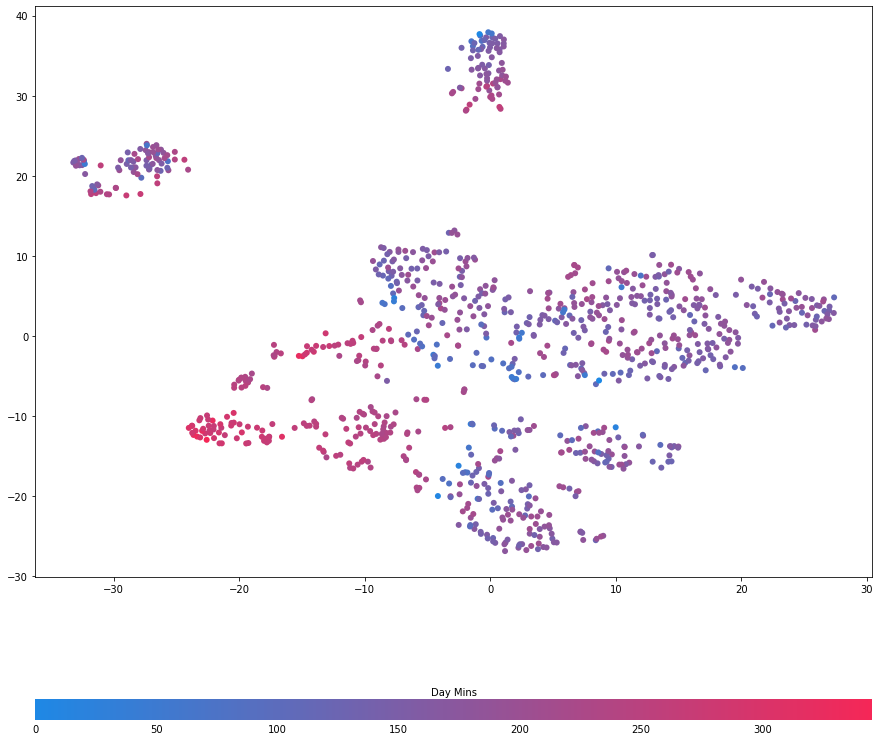

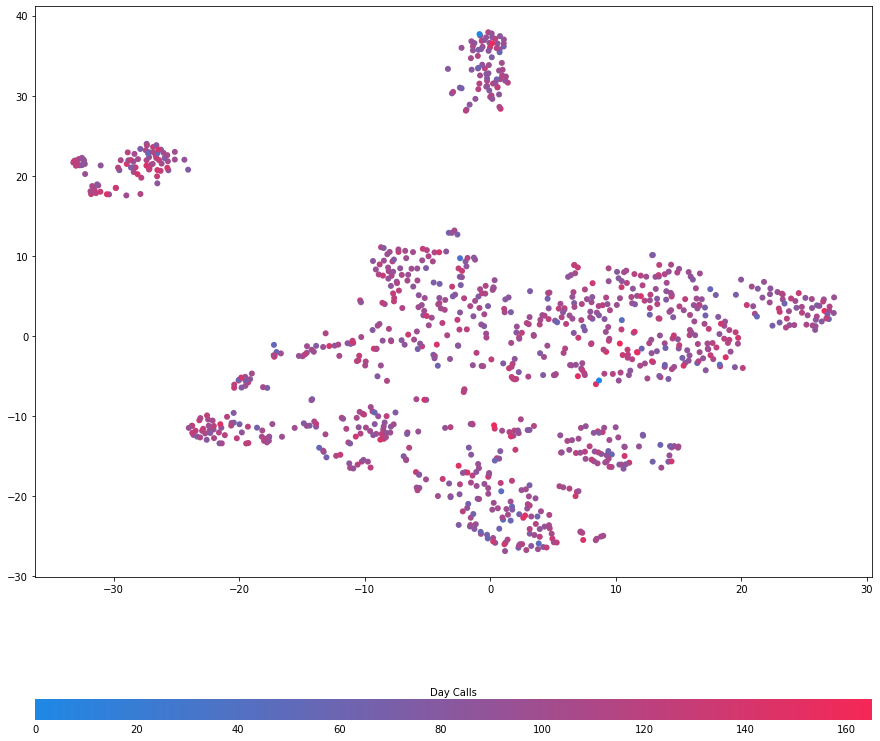

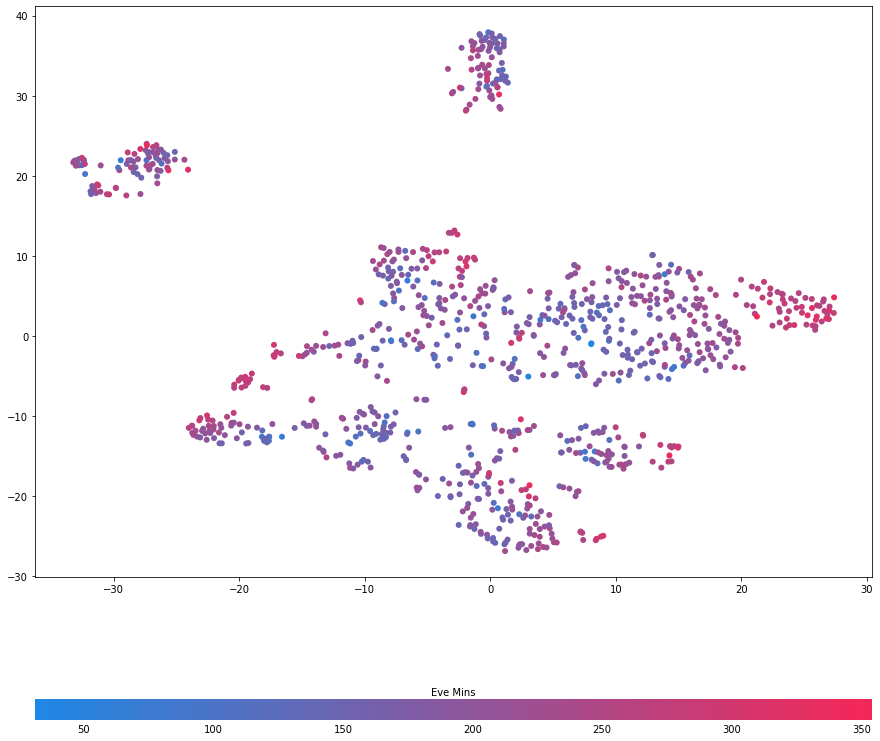

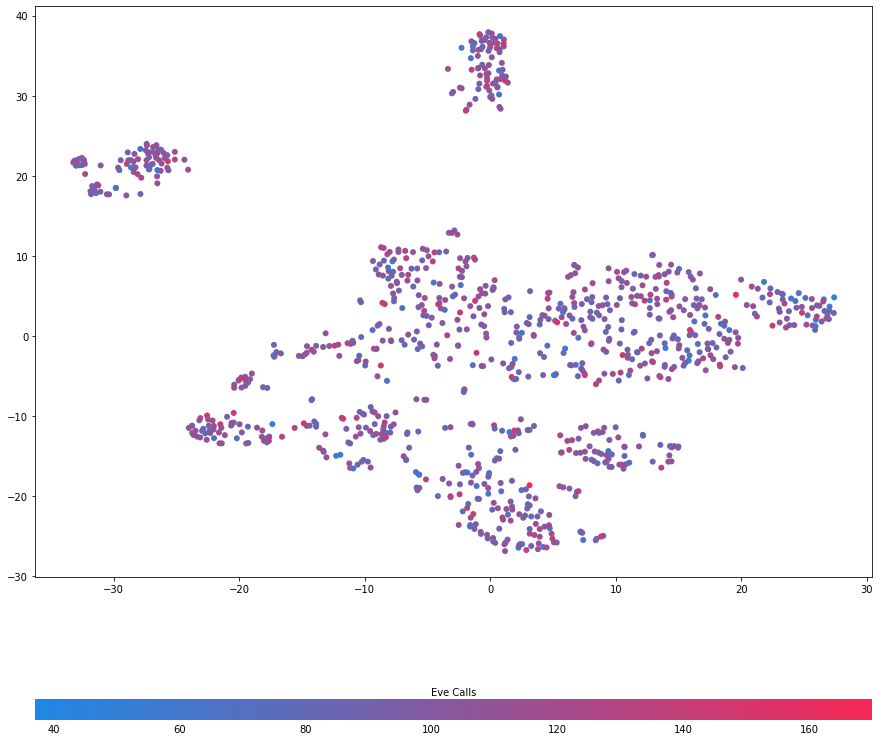

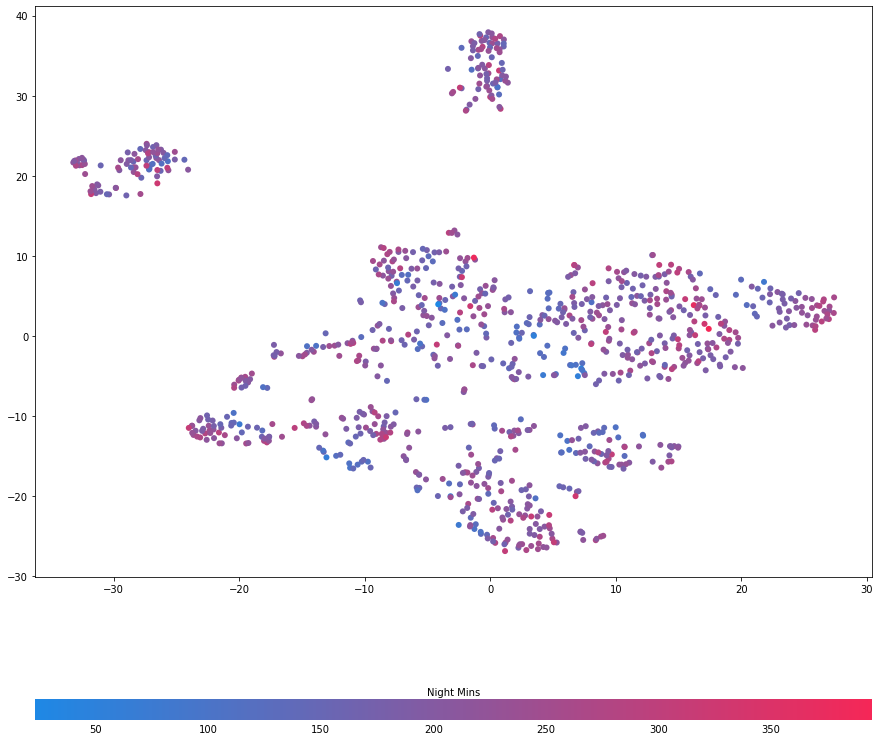

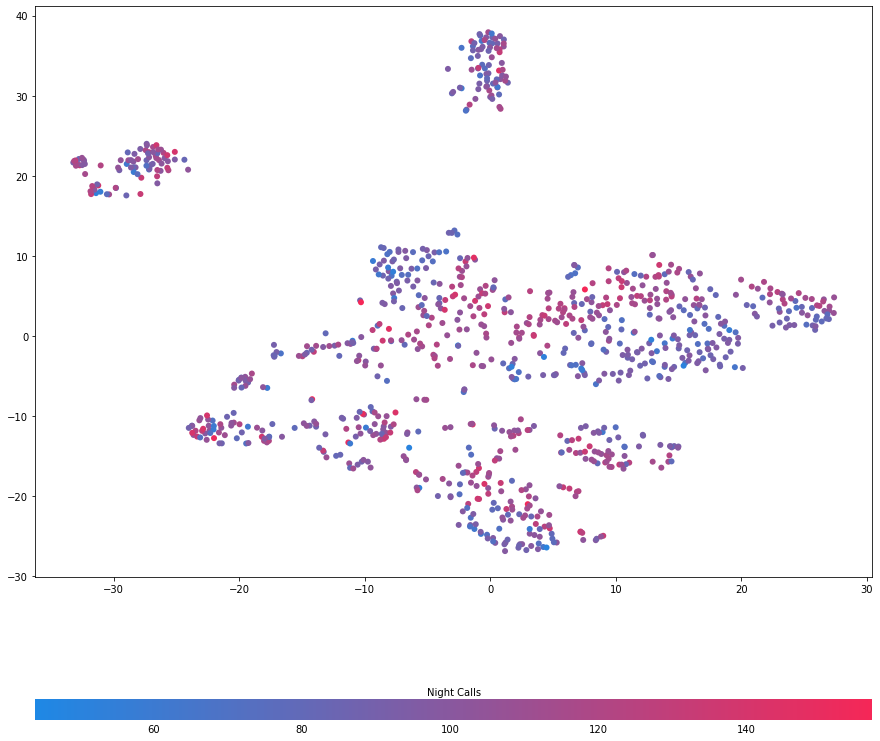

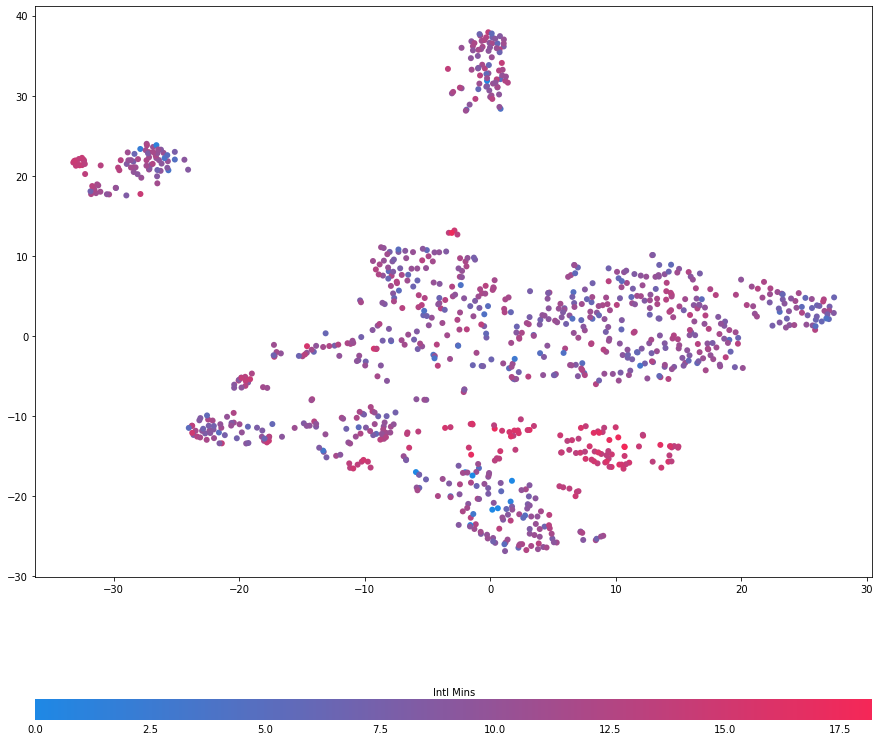

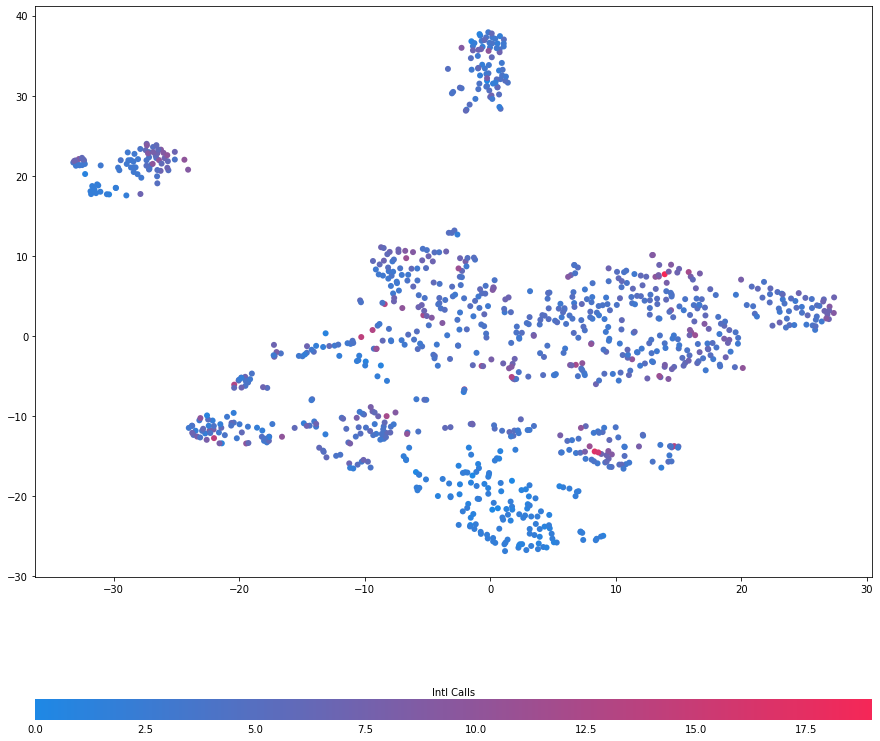

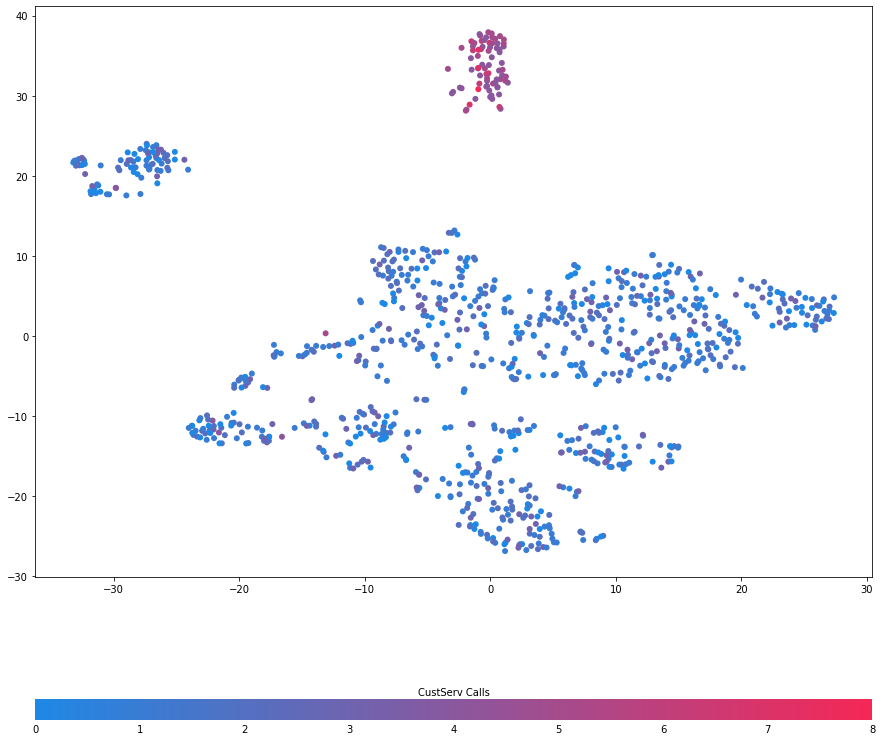

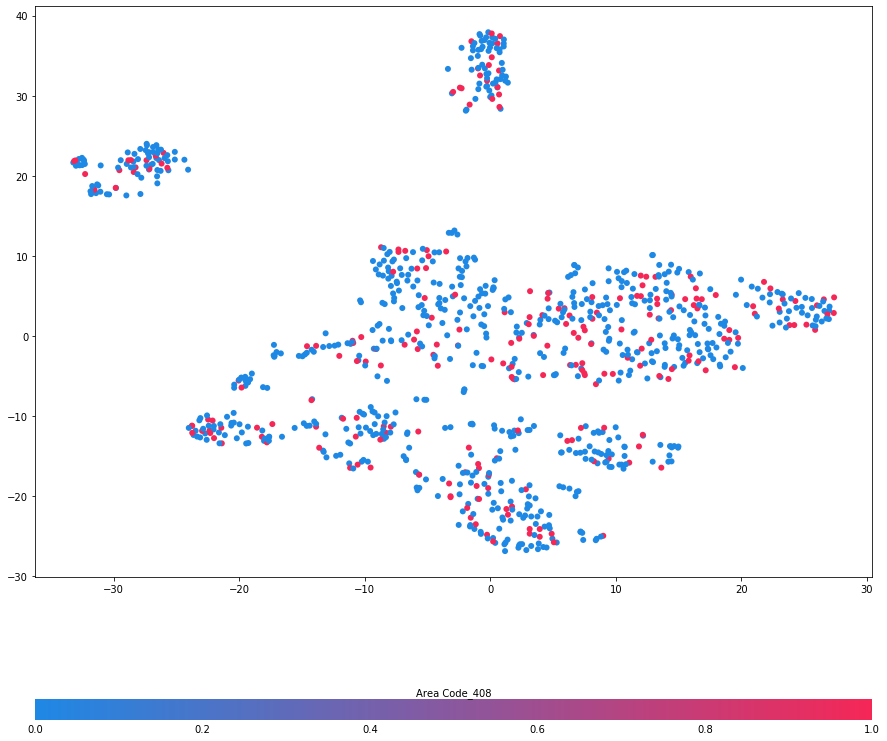

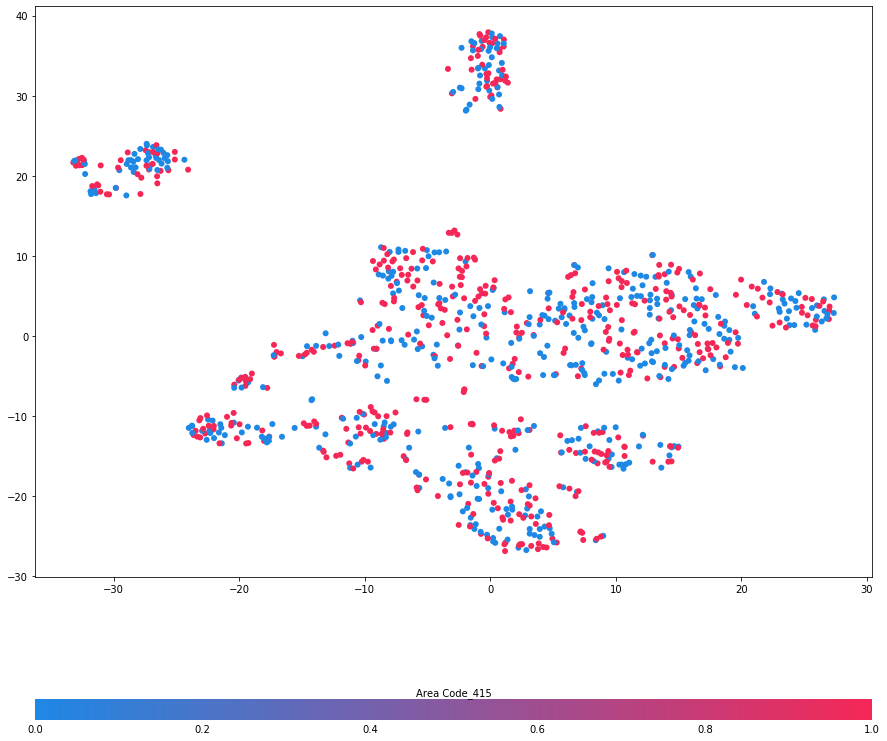

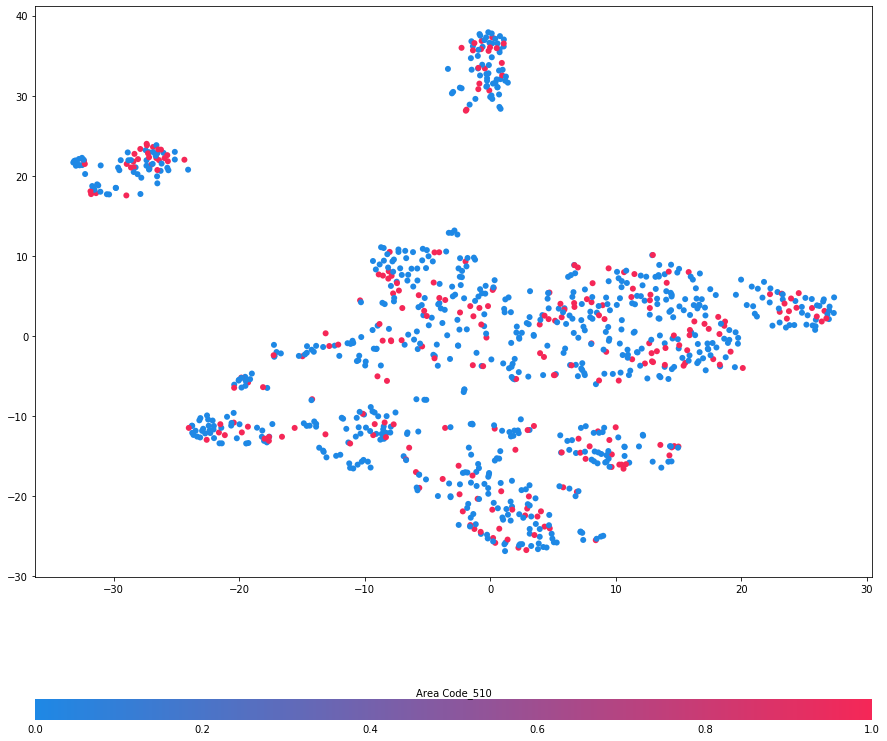

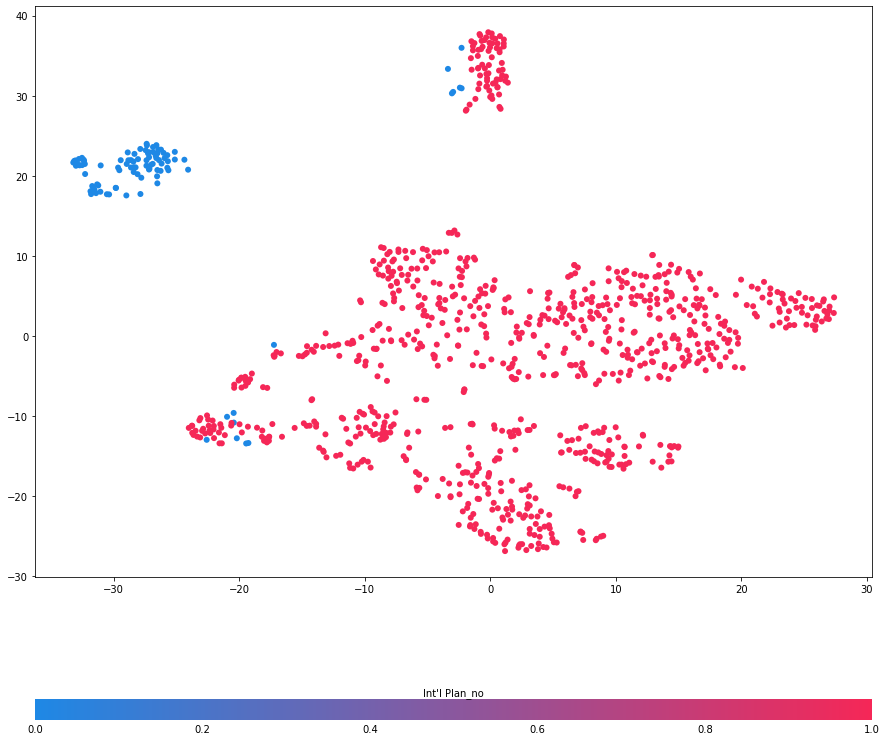

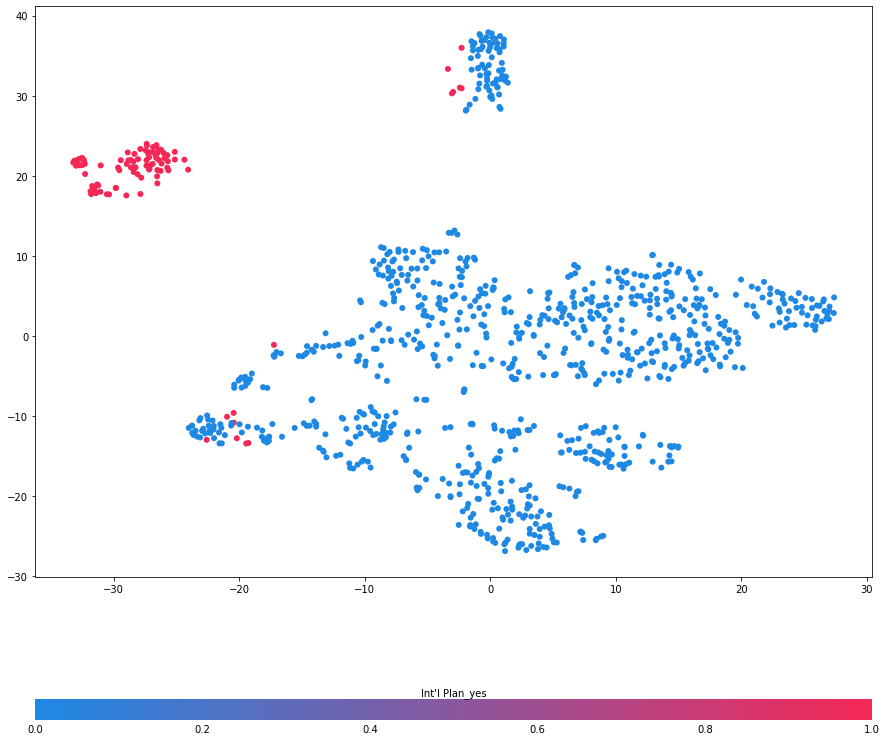

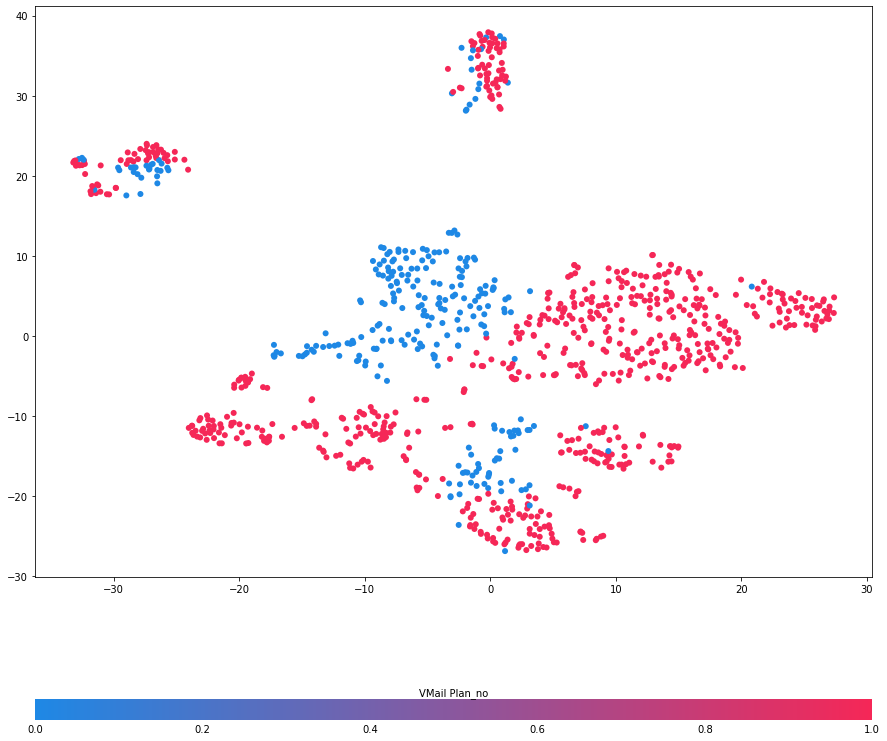

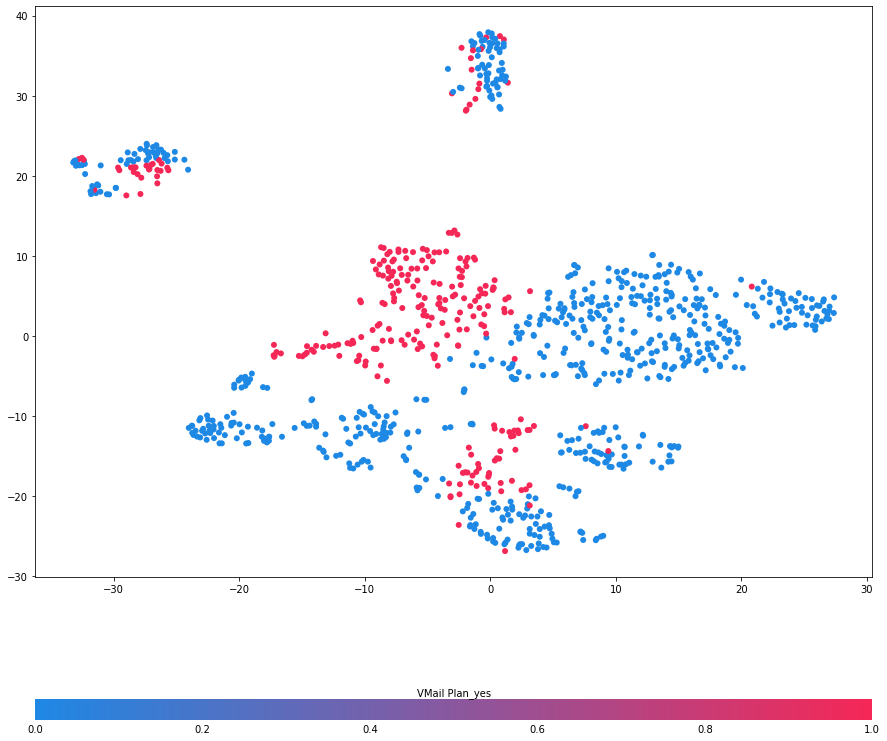

In [103]:
for name in train_data.columns:

    f = pl.figure(figsize=(15,15))
    pl.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=train_data[name].values[:1000].astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = pl.colorbar(label=name, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    pl.gca().axis("on")
    pl.show()

**We can use the above analysis to draw conclusions on what is impacting churn the most.**

For example:



## Hyperparameter tuning

#### A.K.A. Hyperparameter Optimization

We can definitely achieve a better score with XGBoost. However, we don't want to waste time testing all the possible variations of the hyperparameters in order to optimize the training process.

Instead, we'll use the Sagemaker's hyperparameter tuning feature. We'll use the same estimator, but let's create a Tuner and ask it for optimize the model for us. 

In [129]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                         'gamma': ContinuousParameter(0, 10),
                        'max_depth': IntegerParameter(1, 10)}

objective_metric_name = 'validation:error'

# objective_metric_name = 'validation:auc'



tuner = HyperparameterTuner(xgboost_estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10,
                            max_parallel_jobs=3,           
                            objective_type='Minimize')

#                             objective_type='Maximize')

tuner.fit({'train': train_input, 'validation': validation_input, }, wait=False)
# tuner.wait()

Attach tuner job to get metrics and compare


In [126]:
job_name = tuner.latest_tuning_job.name
attached_tuner = HyperparameterTuner.attach(job_name)


In [127]:
job_name

'sagemaker-xgboost-210118-1853'

In [128]:
xgb_predictor = attached_tuner.deploy(initial_instance_count=1, instance_type='ml.t2.medium', serializer=CSVSerializer(), wait=False)


2021-01-18 19:06:31 Starting - Preparing the instances for training
2021-01-18 19:06:31 Downloading - Downloading input data
2021-01-18 19:06:31 Training - Training image download completed. Training in progress.
2021-01-18 19:06:31 Uploading - Uploading generated training model
2021-01-18 19:06:31 Completed - Training job completed


In [130]:
endpoint_name = 'sagemaker-xgboost-210118-1853-009-ead6fe44'
model_name = boto3.client('sagemaker').describe_endpoint_config(
    EndpointConfigName=endpoint_name
)['ProductionVariants'][0]['ModelName']
!echo $model_name > model_name.txt
!echo $endpoint_name > endpoint_name.txt

In [230]:
# from sagemaker.serializers import CSVSerializer
# csv_serializer = CSVSerializer()
from sklearn.metrics import f1_score


endpoint_name = xgb_predictor.endpoint_name
model_name = boto3.client('sagemaker').describe_endpoint_config(
    EndpointConfigName=endpoint_name
)['ProductionVariants'][0]['ModelName']
!echo $model_name > model_name.txt
!echo $endpoint_name > endpoint_name.txt
xgb_predictor.serializer = csv_serializer

---
## Host

Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

In [167]:
xgb_predictor = compiled_model.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.m4.xlarge',
    serializer=CSVSerializer())

Using already existing model: deployed-xgboost-customer-churn


---------------!

### Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [155]:
xgboost_estimator??

Type:           Estimator
String form:    <sagemaker.estimator.Estimator object at 0x7f534c9bb8d0>
File:           ~/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker/estimator.py
Source:        
class Estimator(EstimatorBase):
    """A generic Estimator to train using any supplied algorithm.

    This class is designed for use with algorithms that don't have their own, custom class.
    """

    def __init__(
        self,
        image_uri,
        role,
        instance_count=None,
        instance_type=None,
        volume_size=30,
        volume_kms_key=None,
        max_run=24 * 60 * 60,
        input_mode="File",
        output_path=None,
        output_kms_key=None,
        base_job_name=None,
        sagemaker_session=None,
        hyperparameters=None,
        tags=None,
        subnets=None,
        security_group_ids=None,
        model_uri=None,
        model_channel_name="model",
        metric_definitions=None,
        encrypt_inter_container_traffic=False,
  

In [148]:
xgboost_estimator.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.m4.xlarge',
    serializer=CSVSerializer())

---------------!

In [6]:
import sagemaker
sess = sagemaker.Session()
from sagemaker.serializers import CSVSerializer


In [20]:
import pandas as pd
import numpy as np

In [18]:
test_data = pd.read_csv('test_data.csv')
test_data

0.000  186.000  0.000.1  137.800  97.000  187.700  118.000  146.400  \
0      0.0    132.0     25.0    113.2    96.0    269.9    107.0    229.1   
1      0.0    112.0     17.0    183.2    95.0    252.8    125.0    156.7   
2      0.0     91.0     24.0     93.5   112.0    183.4    128.0    240.7   
3      0.0     22.0      0.0    110.3   107.0    166.5     93.0    202.3   
4      0.0    102.0      0.0    186.8    92.0    173.7    123.0    250.9   
..     ...      ...      ...      ...     ...      ...      ...      ...   
328    0.0     59.0      0.0    166.3    95.0    239.3     87.0    123.2   
329    0.0    127.0     14.0    143.2    99.0    169.9     91.0    221.6   
330    0.0     86.0      0.0    166.2   112.0    255.3     81.0    228.1   
331    0.0     36.0     43.0     29.9   123.0    129.1    117.0    325.9   
332    0.0    123.0      0.0    163.1   119.0    249.4     51.0    168.2   

     85.000  8.700  6.000  1.000  0.000.2  0.000.3  1.000.1  1.000.2  0.000.4  \
0      87.0    7.1    7.0    2.0      0.0      1.0      0.0      1.0      0.0   
1      95.0    9.7    3.0    0.0      0.0      1.0      0.0      1.0      0.0   
2     133.0    9.9    3.0    0.0      0.0      0.0      1.0      0.0      1.0   
3      96.0    9.5    5.0    0.0      1.0      0.0      0.0      1.0      0.0   
4     131.0    9.7    4.0    2.0      0.0      1.0      0.0      1.0      0.0   
..      ...    ...    ...    ...      ...      ...      ...      ...      ...   
328   108.0   10.0    3.0    2.0      0.0      0.0      1.0      1.0      0.0   
329    77.0   11.6    1.0    1.0      0.0      1.0      0.0      1.0      0.0   
330    97.0    5.4    7.0    1.0      0.0      1.0      0.0      1.0      0.0   
331   105.0    8.6    6.0    2.0      1.0      0.0      0.0      1.0      0.0   
332    77.0    9.0   10.0    1.0      0.0      1.0      0.0      1.0      0.0   

     1.000.3  0.000.5  
0        0.0      1.0  
1        0.0      1.0  
2        0.0      1.0  
3        1.0      0.0  
4        1.0      0.0  
..       ...      ...  
328      1.0      0.0  
329      0.0      1.0  
330      1.0      0.0  
331      0.0      1.0  
332      1.0      0.0  

[333 rows x 19 columns]

In [7]:
# xgb_predictor3 = sagemaker.predictor.Predictor('Pipeline-development', sagemaker_session=sess, serializer=CSVSerializer())

In [24]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.to_numpy()[:,1:])
predictions

array([0.04594088, 0.04338237, 0.12121402, 0.04115116, 0.05016112,
       0.69511759, 0.04656969, 0.13465706, 0.04349471, 0.06287679,
       0.05450993, 0.04115116, 0.07602978, 0.05016112, 0.07992861,
       0.04376415, 0.04624721, 0.33008528, 0.04115116, 0.04624721,
       0.61024028, 0.0561538 , 0.04115116, 0.05498401, 0.10902666,
       0.04115116, 0.93427795, 0.04620972, 0.05279603, 0.04115116,
       0.07571053, 0.04349471, 0.04115116, 0.04338237, 0.63448483,
       0.04349471, 0.04115116, 0.05881285, 0.06918161, 0.04115116,
       0.10668433, 0.05279603, 0.04624721, 0.05202799, 0.81295007,
       0.04975453, 0.04115116, 0.05450993, 0.05256119, 0.04452354,
       0.05016112, 0.14879617, 0.05016112, 0.33982924, 0.04115116,
       0.04554102, 0.54581392, 0.04624721, 0.05240234, 0.22197875,
       0.04115116, 0.10079587, 0.04624721, 0.04656969, 0.04376415,
       0.04115116, 0.04115116, 0.07528707, 0.04624721, 0.04656969,
       0.31009188, 0.04115116, 0.08172955, 0.05162812, 0.67544

There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  In this case, we're simply predicting whether the customer churned (`1`) or not (`0`), which produces a simple confusion matrix.

In [22]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions  0.0  1.0
actual               
0.0          282    3
1.0           12   36

In [136]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions  0.0  1.0
actual               
0            282    4
1             14   34

_Note, due to randomized elements of the algorithm, you results may differ slightly._

Of the 48 churners, we've correctly predicted 39 of them (true positives). And, we incorrectly predicted 4 customers would churn who then ended up not doing so (false positives).  There are also 9 customers who ended up churning, that we predicted would not (false negatives).

An important point here is that because of the `np.round()` function above we are using a simple threshold (or cutoff) of 0.5.  Our predictions from `xgboost` come out as continuous values between 0 and 1 and we force them into the binary classes that we began with.  However, because a customer that churns is expected to cost the company more than proactively trying to retain a customer who we think might churn, we should consider adjusting this cutoff.  That will almost certainly increase the number of false positives, but it can also be expected to increase the number of true positives and reduce the number of false negatives.

To get a rough intuition here, let's look at the continuous values of our predictions.

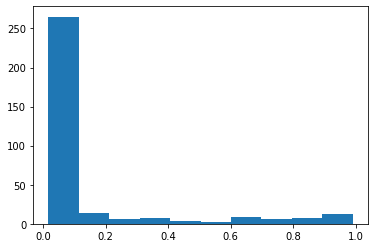

In [137]:
plt.hist(predictions)
plt.show()

The continuous valued predictions coming from our model tend to skew toward 0 or 1, but there is sufficient mass between 0.1 and 0.9 that adjusting the cutoff should indeed shift a number of customers' predictions.  For example...

In [165]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.2, 1, 0), rownames=['actual'], colnames=['predictions'])

predictions    0   1
actual              
0            270  16
1              7  41

We can see that changing the cutoff from 0.5 to 0.3 results in 1 more true positives, 3 more false positives, and 1 fewer false negatives.  The numbers are small overall here, but that's 6-10% of customers overall that are shifting because of a change to the cutoff.  Was this the right decision?  We may end up retaining 3 extra customers, but we also unnecessarily incentivized 5 more customers who would have stayed.  Determining optimal cutoffs is a key step in properly applying machine learning in a real-world setting.  Let's discuss this more broadly and then apply a specific, hypothetical solution for our current problem.

### Relative cost of errors

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with and might even be solvable with simple rules instead of ML.

More important, if I put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. I also need to look at similar costs associated with correct predictions of true positives and true negatives.  Because the choice of the cutoff affects all four of these statistics, I need to consider the relative costs to the business for each of these four outcomes for each prediction.

#### Assigning costs

What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the true negatives the cost of \$0. Our model essentially correctly identified a happy customer in this case, and we don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the purposes of this example, let's assume \$500. This is the cost of false negatives.

Finally, for customers that our model identifies as churning, let's assume a retention incentive in the amount of \$100. If my provider offered me such a concession, I’d certainly think twice before leaving. This is the cost of both true positive and false positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will “waste” the \$100 concession. We probably could have spent that \$100 more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.

#### Finding the optimal cutoff

It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:

```txt
$500 * FN(C) + $0 * TN(C) + $100 * FP(C) + $100 * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs.  We test 100 possible values in the for loop below.

In [187]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(np.sum(np.sum(np.array([[0, 100], [500, 100]]) * 
                               pd.crosstab(index=test_data.iloc[:, 0], 
                                           columns=np.where(predictions > c, 1, 0)))))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()

ValueError: Unable to coerce to DataFrame, shape must be (2, 1): given (2, 2)

In [187]:
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))

Cost is minimized near a cutoff of: 0.18000000000000002 for a cost of: 9700


The above chart shows how picking a threshold too low results in costs skyrocketing as all customers are given a retention incentive.  Meanwhile, setting the threshold too high results in too many lost customers, which ultimately grows to be nearly as costly.  The overall cost can be minimized at \$8400 by setting the cutoff to 0.46, which is substantially better than the \$20k+ I would expect to lose by not taking any action.

In [156]:
from sklearn.metrics import confusion_matrix


In [136]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions  0.0  1.0
actual               
0            282    4
1             14   34

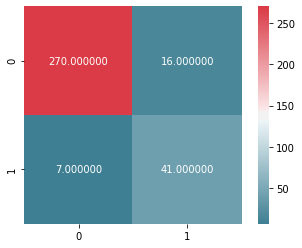

In [171]:
cfm = confusion_matrix(test_data.iloc[:, 0], np.where(predictions > 0.2, 1, 0))
sns.heatmap(cfm, annot=True, fmt="f", square=True, cmap=sns.diverging_palette(220, 10, as_cmap=True))